# Introduction
Try to adapt count-ception to our problem. In addition we also try to parse the filenames and exploit the additional information with a separate path in the network.

### Imports
Import libraries and write settings here.

In [1]:
### IMPORT LIBRARIES ###

# OS operations
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model, Sequential
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Add, Input, Dropout, Activation, Conv2D, MaxPooling2D, UpSampling2D, Lambda, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks, initializers, layers, models, optimizers
from keras import backend as K
import tensorflow as tf
import getpass
import os
from pathlib import Path
import sys

# utilities
import datetime
import itertools
from itertools import chain
import random
import re
from tqdm import tqdm

# data handling
import numpy as np
import pandas as pd

# image manipulation and visualization
import cv2
import imageio
from matplotlib import pyplot as plt
%matplotlib inline

# ML

### SET IMPORTANT PATHS ###

# raw data path
RAW_DATA_PATH = Path(
    "/home/luca/Desktop/countception/original_images/")

# masks path and create directory if does not exist
MASKS_PATH = RAW_DATA_PATH.parent / "all_masks/images"
MASKS_PATH.mkdir(parents=True, exist_ok=True)

# image path and create directory if does not exist
IMG_PATH = RAW_DATA_PATH.parent / "all_images/images"
IMG_PATH.mkdir(parents=True, exist_ok=True)

# masks path and create directory if does not exist
TRAIN_MASKS_PATH = RAW_DATA_PATH.parent / "train/all_masks/images"
TRAIN_MASKS_PATH.mkdir(parents=True, exist_ok=True)

# image path and create directory if does not exist
TRAIN_IMG_PATH = RAW_DATA_PATH.parent / "train/all_images/images"
TRAIN_IMG_PATH.mkdir(parents=True, exist_ok=True)

# masks path and create directory if does not exist
VALID_MASKS_PATH = RAW_DATA_PATH.parent / "validation/all_masks/images"
VALID_MASKS_PATH.mkdir(parents=True, exist_ok=True)

# image path and create directory if does not exist
VALID_IMG_PATH = RAW_DATA_PATH.parent / "validation/all_images/images"
VALID_IMG_PATH.mkdir(parents=True, exist_ok=True)

# test image path and create directory if does not exist
TEST_IMG_PATH = RAW_DATA_PATH.parent / "test/all_images/images"
TEST_IMG_PATH.mkdir(parents=True, exist_ok=True)

# masks path and create directory if does not exist
TEST_MASKS_PATH = RAW_DATA_PATH.parent / "test/all_masks/images"
TEST_MASKS_PATH.mkdir(parents=True, exist_ok=True)

# checkpoint path
MODEL_CHECKPOINTS = RAW_DATA_PATH.parent / "results/model_checkpoints"
MODEL_CHECKPOINTS.mkdir(parents=True, exist_ok=True)

# ### SET GLOBAL VARIABLES ###

# # set radius for circles representing cells
# RADIUS_MAR = 12
# RADIUS_RT = 9

# # for computing reasons we resize the initial image
# IMG_CHANNELS = 3
# IMG_WIDTH = 1600
# IMG_HEIGHT = 1200
# x_fact = 1600/IMG_WIDTH
# y_fact = 1200/IMG_HEIGHT


def count_files_in_directory(count_start=0, dir_list=IMG_PATH):
    if type(dir_list) != type([]):
        dir_list = [dir_list]
    tot_files = count_start
    for directory in dir_list:
        tot_files += sum(1 for _ in directory.iterdir() if _.is_file())
    return tot_files

Using TensorFlow backend.


# Analysis/Modeling
Do work here

## Additional features

In addition to the images themselves, the filenames of each picture are quite informative as well and one may want to bring this extra information into the problem to improve the model performance. In fact, the filenames have a typical structure that could be parsed quite easily to extract some new input features, namely:

- *idx*: identifier of the specific guinea pig
- *sample*: identifier of the brain slice
- *col*: column position of the brain slice onto the grid analyzed with the microscope
- *row*: row position of the brain slice onto the grid analyzed with the microscope
- *tissue*: brain tissue type
- *zoom*: zoom condition for that picture
- *color*: color induced by the marker of interest

In [2]:
import re


def parse_img_name(img_name, idx_short=True):
    '''Filename parser. Takes the image name as input and returns the additional features.

    Keyword arguments:
    img_name -- string with image name
    idx_short -- bool for whether to retain just the species or also the guinea pig identifier (default: True)

    Return: dictionary of features.'''
    if type(img_name) != type(''):
        img_name = str(img_name.name)
    try:
        idx = img_name[:img_name.index("S")]
        if idx_short:
            idx = " ".join(re.findall("[a-zA-Z]+", idx))
        sample = img_name[img_name.index("S"):img_name.index("S")+2]
        col = img_name[img_name.index("C"):img_name.index("C")+2]
        row = img_name[img_name[1:].index("R")+1:img_name[1:].index("R")+3]
    except ValueError:
        print("WARNING: not possible to parse", img_name,
              "\nString format isn't as expected up to raw element")
    try:
        tissue = img_name.split("_")[1]
        zoom = img_name.split("_")[2]
        color = img_name.split("_")[3].split(".")[0]
    except IndexError:
        print("WARNING: not possible to parse", img_name,
              "\nString format isn't as expected after tissue")
#     print(img_name)
#     print(idx, sample, col, row, tissue, zoom, color)
    feature_dict = {'idx': idx,
                    'sample': sample,
                    'col': col,
                    'row': row,
                    'tissue': tissue,
                    'zoom': zoom,
                    'color': color
                    }
    return(feature_dict)


# parse_img_name("RT428S5C1R1_DM_100x_g.TIF")

In [3]:
additional_features = pd.DataFrame()

for folder in RAW_DATA_PATH.iterdir():
    for img_name in folder.iterdir():
        if img_name.is_file():
            if img_name.name.endswith(".TIF"):
                additional_features = additional_features.append(pd.DataFrame(
                    [parse_img_name(img_name.name, idx_short=False)], index=[img_name.name]))

save_path = RAW_DATA_PATH.parent / "additional_features.txt"
additional_features.to_csv(save_path, sep='\t', index_label="original_name")

**Inspect additional features table**

In [4]:
additional_features.head()

,col,color,idx,row,sample,tissue,zoom
RT433S4C1R2_LH_100x_g.TIF,C1,g,RT433,R2,S4,LH,100x
RT433S4C1R1_ParCortex_100x_g.TIF,C1,g,RT433,R1,S4,ParCortex,100x
RT433S5C2R2_MM_100x_g.TIF,C2,g,RT433,R2,S5,MM,100x
RT433S6C3R2_RVLM_100x_g.TIF,C3,g,RT433,R2,S6,RVLM,100x
RT433S5C4R2_VLPAG_100x_g.TIF,C4,g,RT433,R2,S5,VLPAG,100x


**yellow images**

In [5]:
additional_features[additional_features.color=='y'].shape

(252, 7)

**green images**

In [6]:
additional_features[additional_features.color=='g'].shape

(307, 7)

## Coordinates map

In [33]:
# first re-organize the data
full_map = pd.DataFrame()
frames = []
for folder in RAW_DATA_PATH.iterdir():
    map_path = folder / 'nomi.txt'
    name_map = pd.read_csv(str(map_path), delimiter="\t", header=None)
    name_map.columns = ["original_name", "original_tag", "imagepro_name"]
    name_map["folder"] = str(folder.name)
#     full_map = pd.concat([name_map], ignore_index=True)
    frames.append(name_map)

full_map = pd.concat(frames, ignore_index=True)

In [34]:
full_map.head()

,original_name,original_tag,imagepro_name,folder
0,RT433S4C1R2_DM_100x_g.TIF,RT433S4C1R2_DM_cFos+.tag,campione0,RT433
1,RT433S6C3R2_RVLM_100x_g.TIF,RT433S6C3R2_RVLM_cFos+.tag,campione1,RT433
2,RT433S4C1R1_ParCortex_100x_g.TIF,RT433S4C1R1_ParCortex_cFos+.tag,campione2,RT433
3,RT433S2C2R1_Septum_100x_g.TIF,RT433S2C2R1_Septum_cFos+.tag,campione3,RT433
4,RT433S5C4R2_VLPAG_100x_g.TIF,RT433S5C4R2_VLPAG_cFos+.tag,campione4,RT433


### **Visualise how dotted annotations can be created**

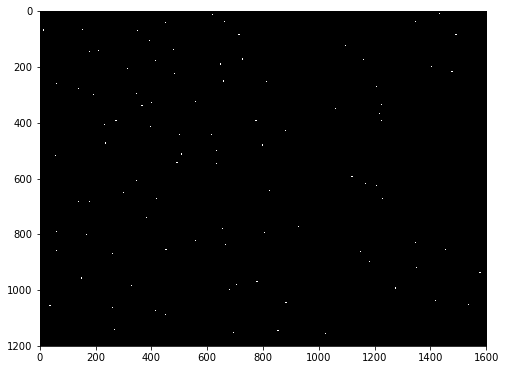

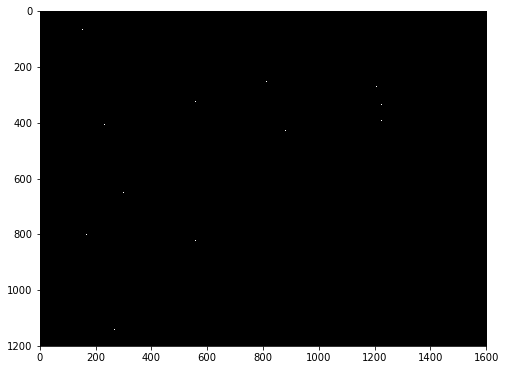

CPU times: user 1.2 s, sys: 1.08 s, total: 2.28 s
Wall time: 484 ms


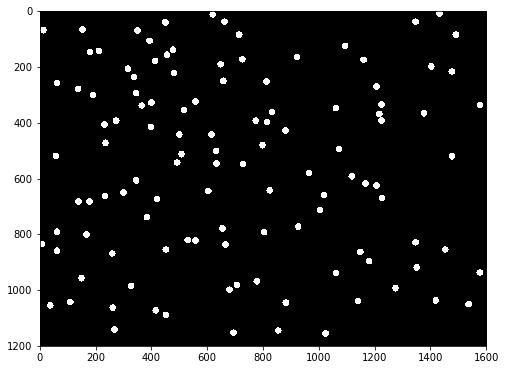

In [35]:
%%time

IMG_HEIGHT = 1200
IMG_WIDTH = 1600

element_to_inspect = 115

# initialize new column for the mask name to MISSING
full_map["mask_name"] = "MISSING"

# read coordinates files per each image
for img_idx in range(full_map.shape[0]):
    
    
    if img_idx==element_to_inspect:

        folder = full_map.loc[img_idx]["folder"]
        imagepro_name = full_map.loc[img_idx]["imagepro_name"]
        # get the path of the file containing the coordinates
        coordinates_path = RAW_DATA_PATH / (folder + "/coordinates/"
                                                   + imagepro_name
                                                   + "_points_.txt")

        # open coordinates file
        with open(str(coordinates_path), 'r') as file:

            # initialize lists for the final
            coordinates = []

            # read coordinates record from file
            for line in file:
                if line.replace(' ', '').startswith('P'):
                    continue
                # filter only columns containing x/y coordinates
                coordinates.append(line.split('\t')[2:4])
                numeric_coordinates = [[int(j) for j in i] for i in coordinates]

        # initialized 3-channels black image for the mask
        img = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3], dtype=np.uint8)
        img.fill(0)
        img2 = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3], dtype=np.uint8)
        img2.fill(0)
        img3 = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3], dtype=np.uint8)
        img3.fill(0)
        # add a circle for each dot
        try:
            for pt in numeric_coordinates:
                img3[pt[1], pt[0],:] = [255, 255, 255]
                cv2.circle(img, (pt[0], pt[1]), 2, [255, 255, 255], -1)
                cv2.circle(img2, (pt[0], pt[1]), 12, [255, 255, 255], -1)
        except NameError:
            print("\nNo coordinates in file: ", coordinates_path)    

        # save the mask to the appropriate folder
        output_path = MASKS_PATH / 'campione{}.TIF'.format(img_idx)

        plt.figure(figsize=(8,12))
        plt.imshow(img)
        plt.show()
        plt.figure(figsize=(8,12))
        plt.imshow(img3)
        plt.show()
        plt.figure(figsize=(8,12))
        plt.imshow(img2)

### **Verify that objects' counts are correctly reproduced in the masks**

In [36]:
from scipy import ndimage

_, c3 = ndimage.label(img3)
_, c2 = ndimage.label(img2)
_, c = ndimage.label(img)

len(numeric_coordinates), c, c2, c3

(116, 116, 116, 116)

<div class="alert alert-block alert-warning">
    <b>Note:</b> cv2.circle may produce unexpected counts due to single pixels on the circumference that are counted as single objects by <i>ndimage.label</i>. Also, dots which are really close may overlap after drawing circles around them, thus resulting in one, bigger cell.
</div>

### **Visualise how well dots annotations localise the cells in the original images**

0 Mar27b 198 1400


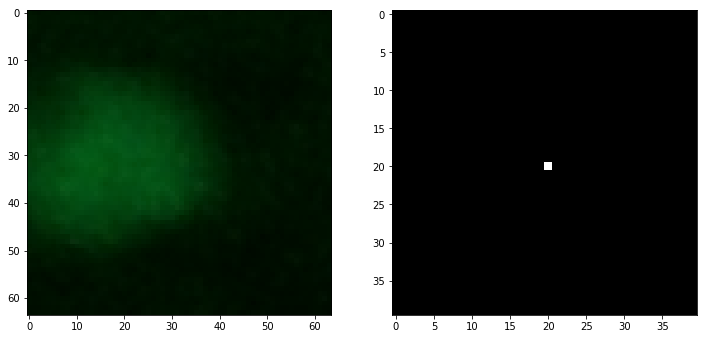

1 Mar27b 216 1474


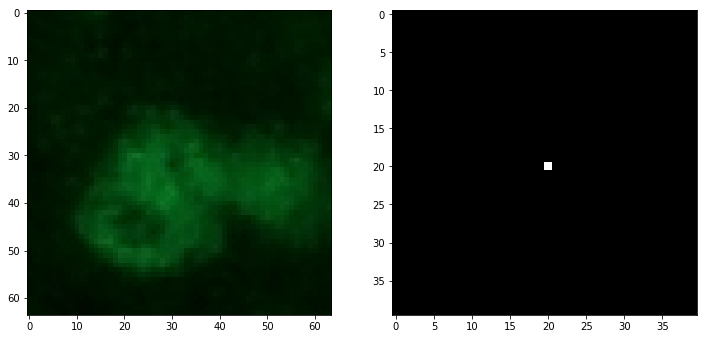

2 Mar27b 84 1488


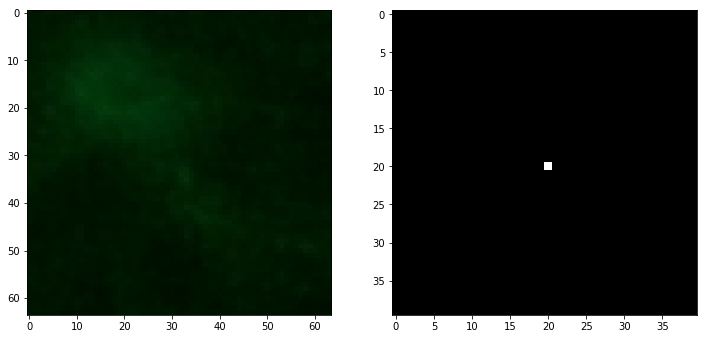

3 Mar27b 8 1430
Not possible to draw 32x32 window around dot annotation.

4 Mar27b 38 1344


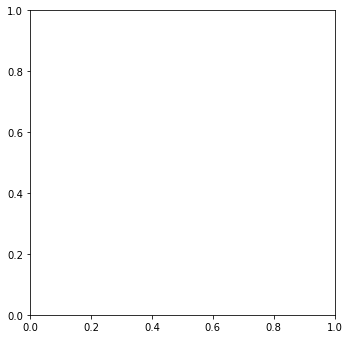

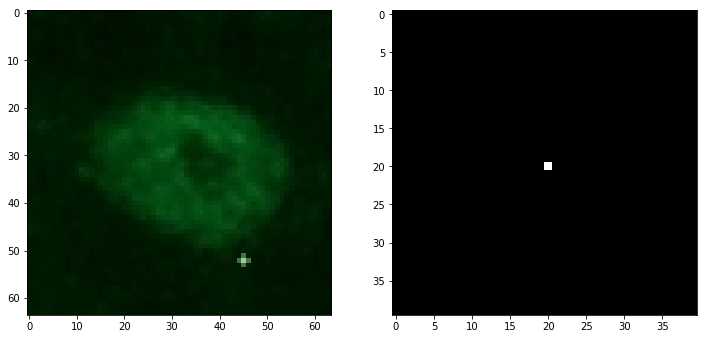

5 Mar27b 336 1574


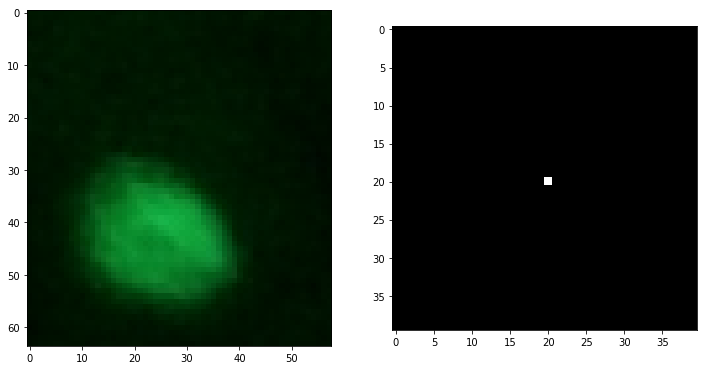

6 Mar27b 366 1374


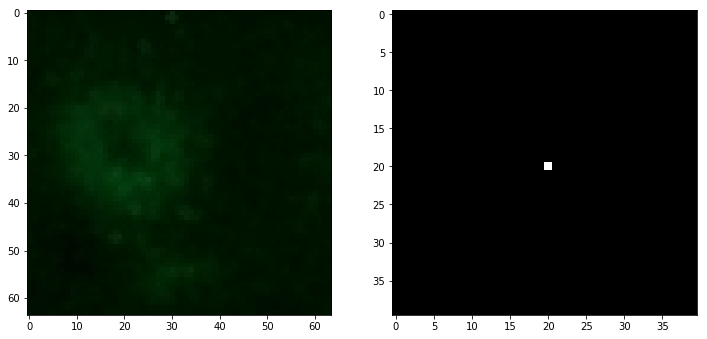

7 Mar27b 520 1474


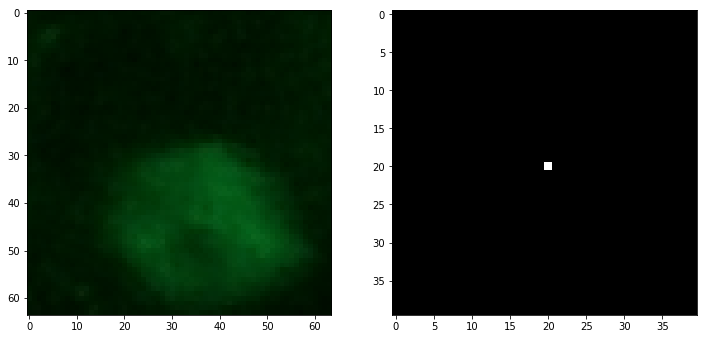

8 Mar27b 854 1450


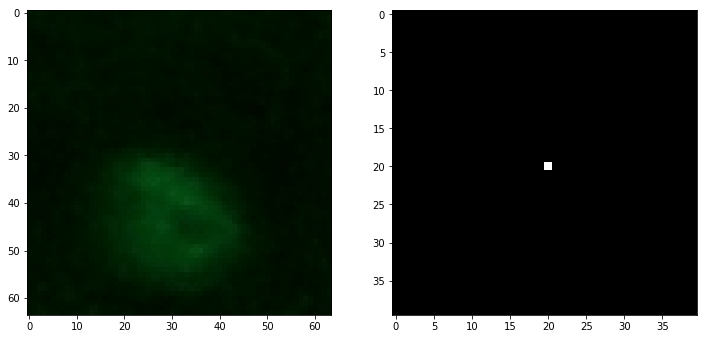

9 Mar27b 828 1344


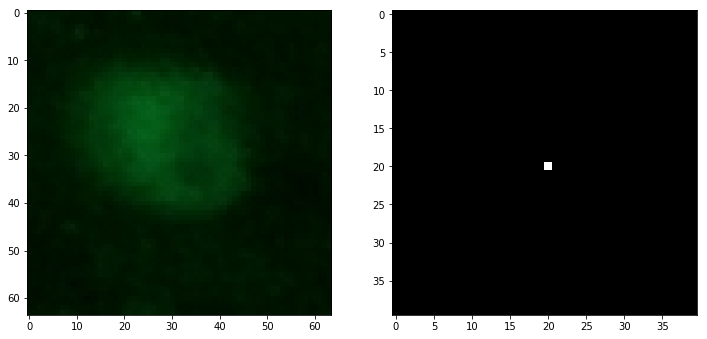

10 Mar27b 670 1224


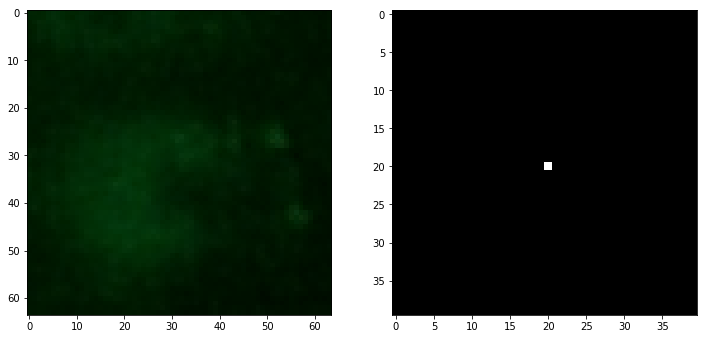

11 Mar27b 624 1204


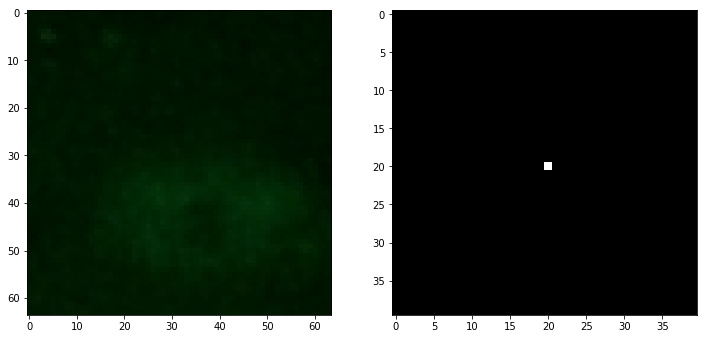

12 Mar27b 618 1164


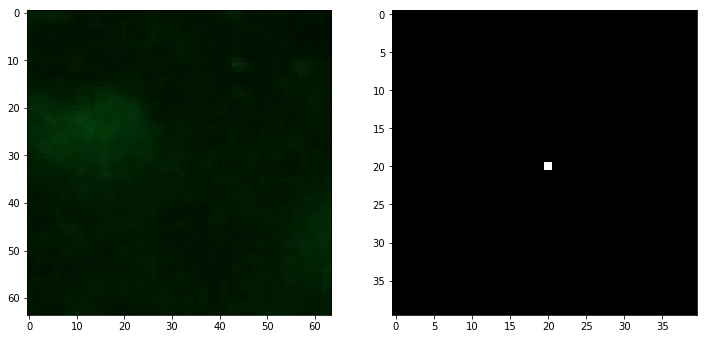

13 Mar27b 592 1116


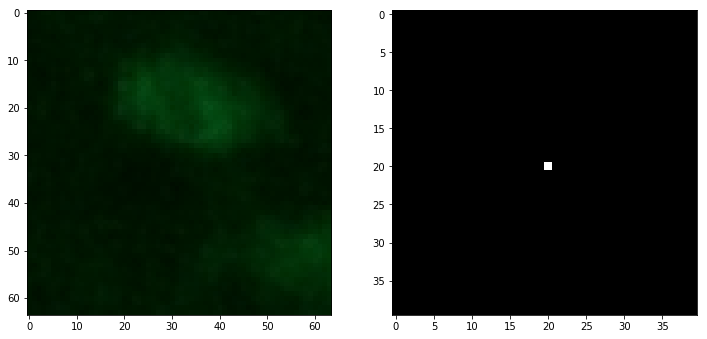

14 Mar27b 494 1070


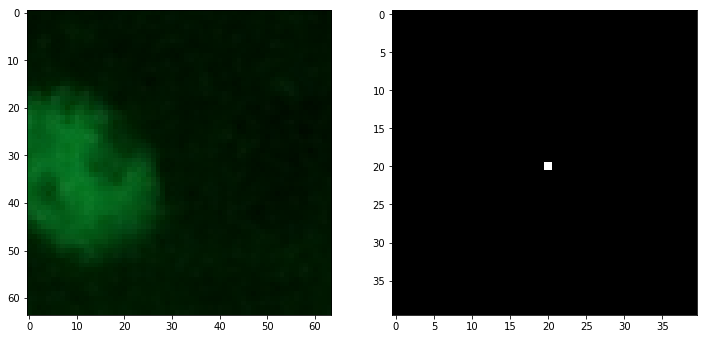

15 Mar27b 348 1058


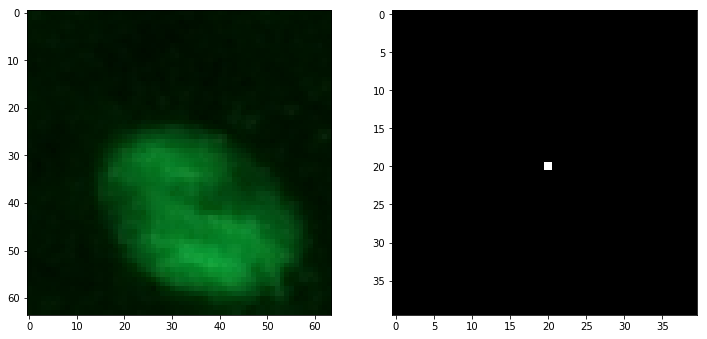

16 Mar27b 392 1222


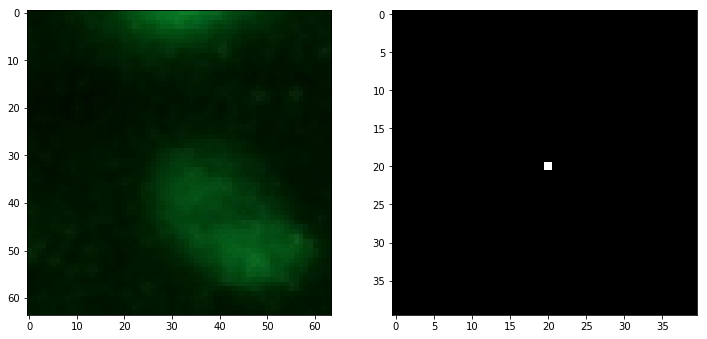

17 Mar27b 368 1214


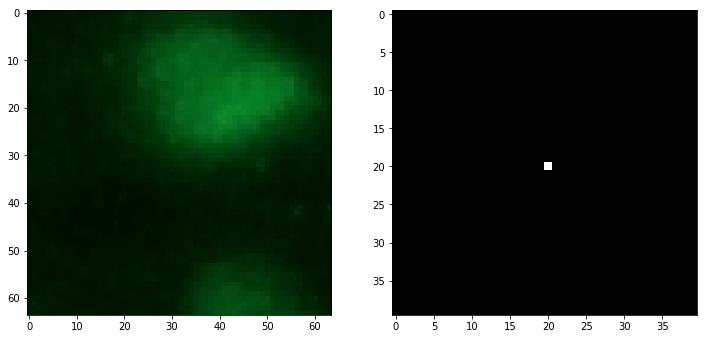

18 Mar27b 334 1222


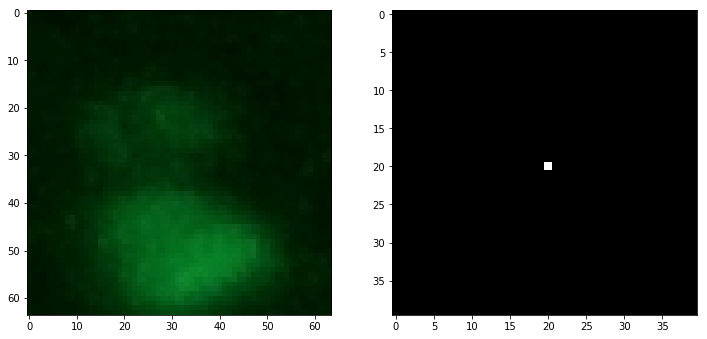

19 Mar27b 270 1204


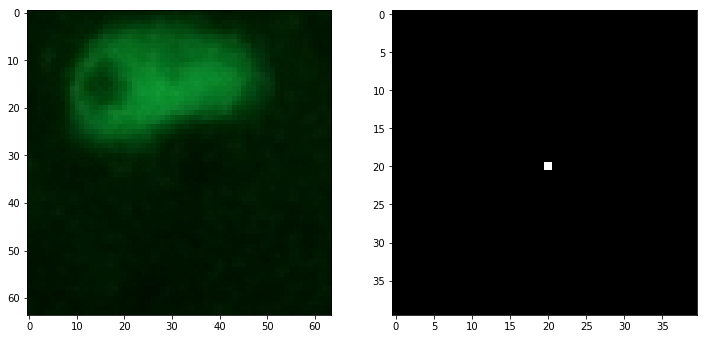

20 Mar27b 174 1158


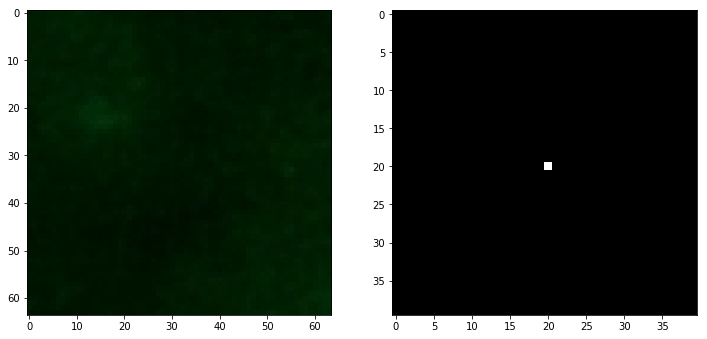

21 Mar27b 252 810


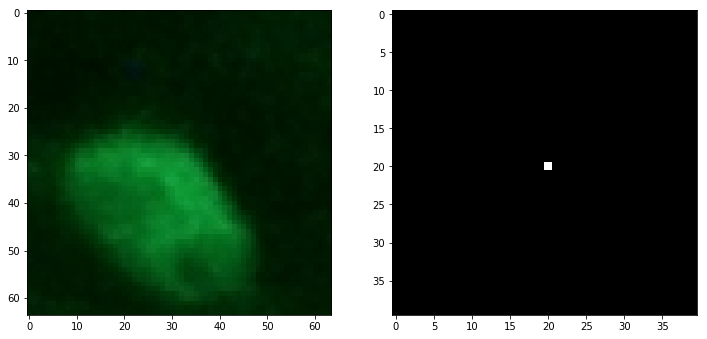

22 Mar27b 172 724


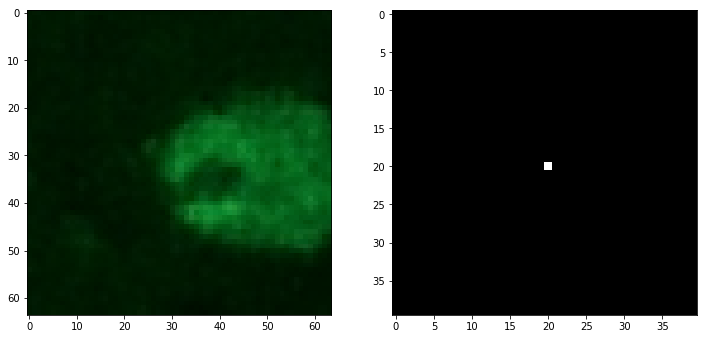

23 Mar27b 38 660


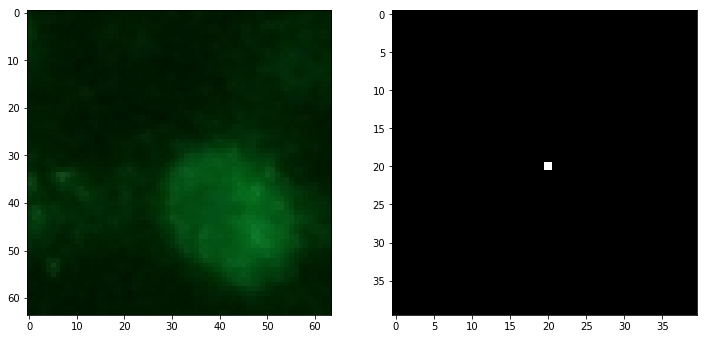

24 Mar27b 12 618
Not possible to draw 32x32 window around dot annotation.

25 Mar27b 84 712


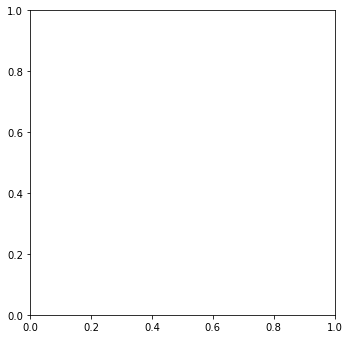

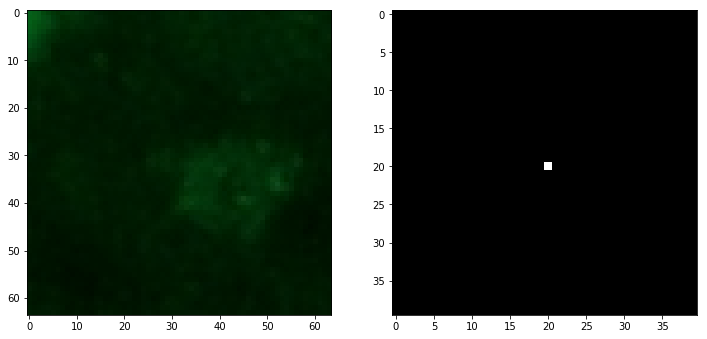

26 Mar27b 190 646


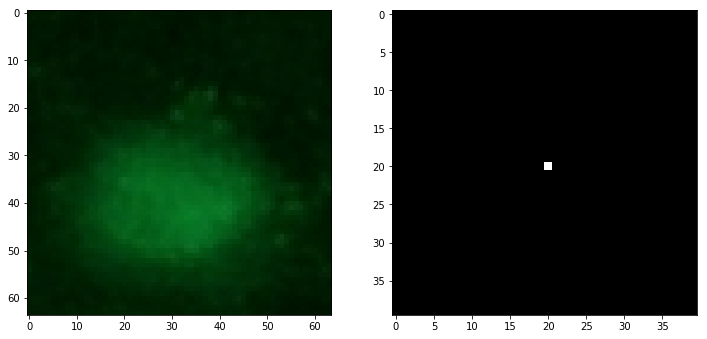

27 Mar27b 250 656


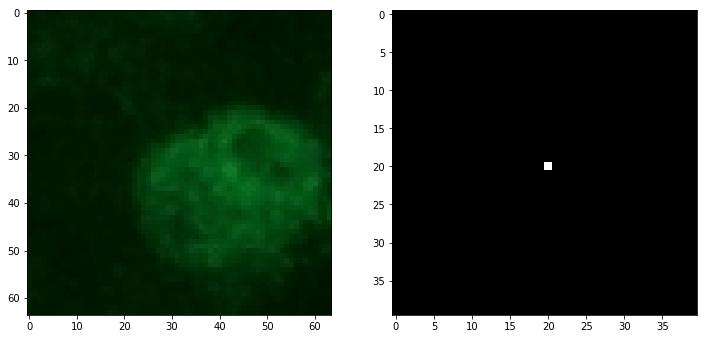

28 Mar27b 392 772


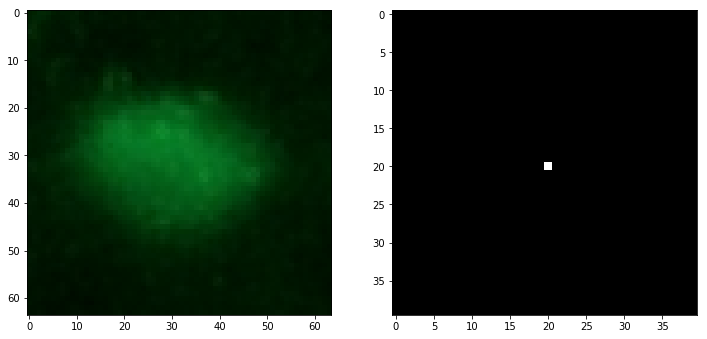

29 Mar27b 398 812


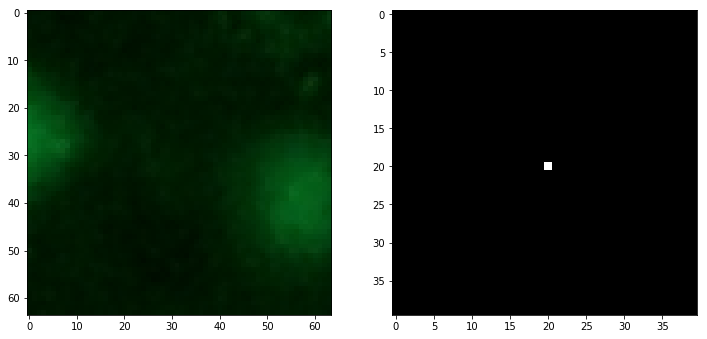

30 Mar27b 362 830


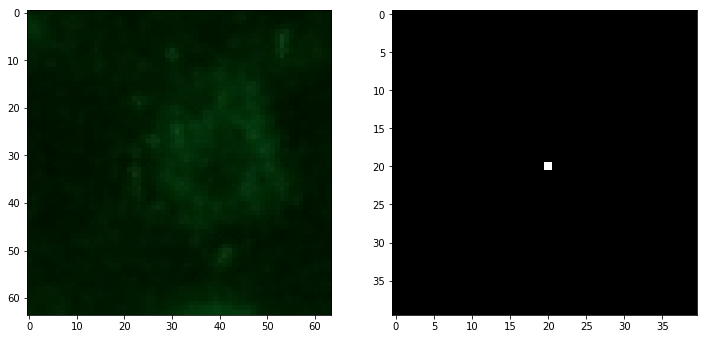

31 Mar27b 428 878


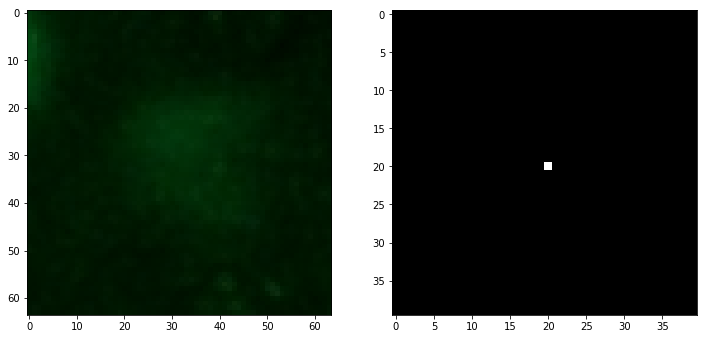

32 Mar27b 480 796


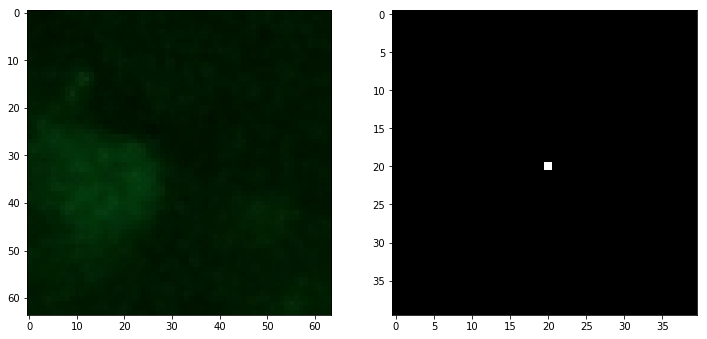

33 Mar27b 548 726


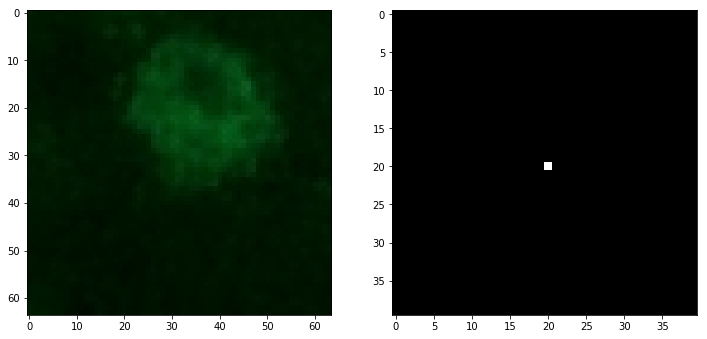

34 Mar27b 546 632


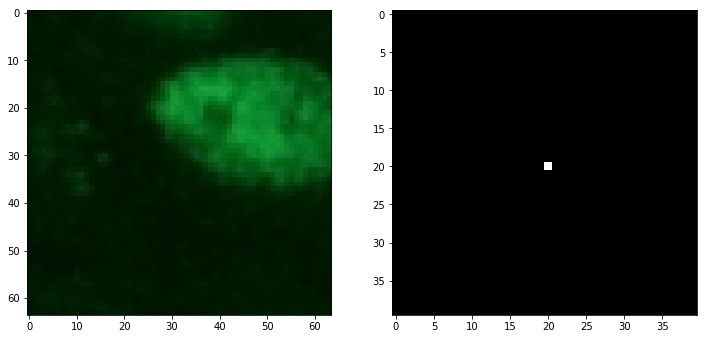

35 Mar27b 500 630


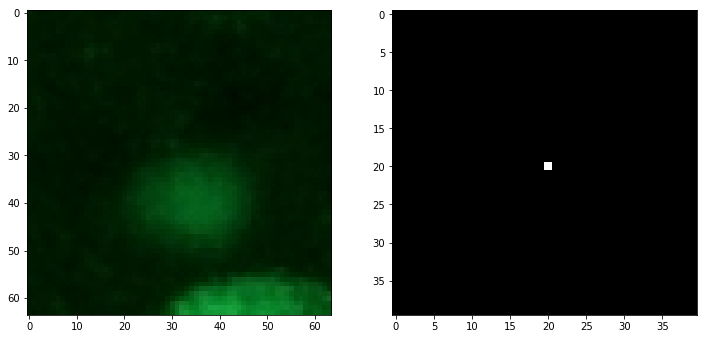

36 Mar27b 442 614


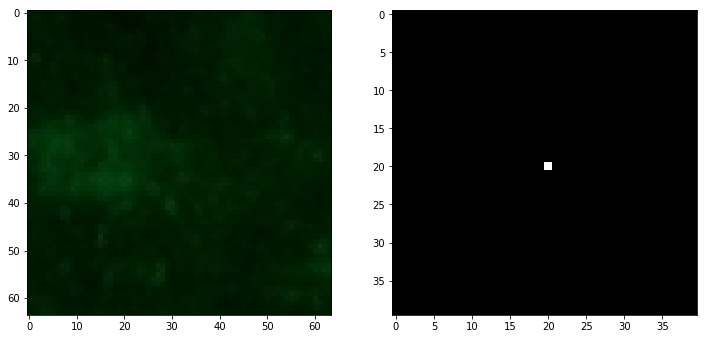

37 Mar27b 324 556


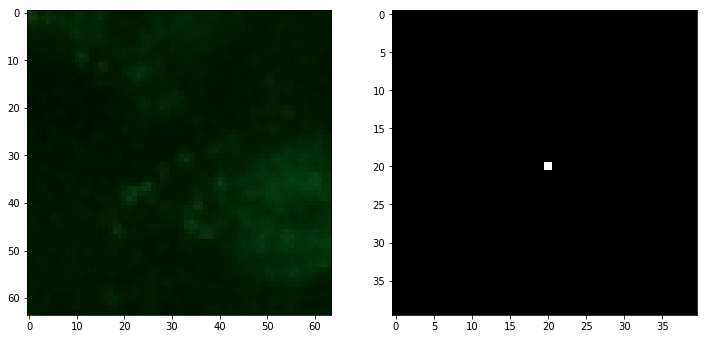

38 Mar27b 442 498


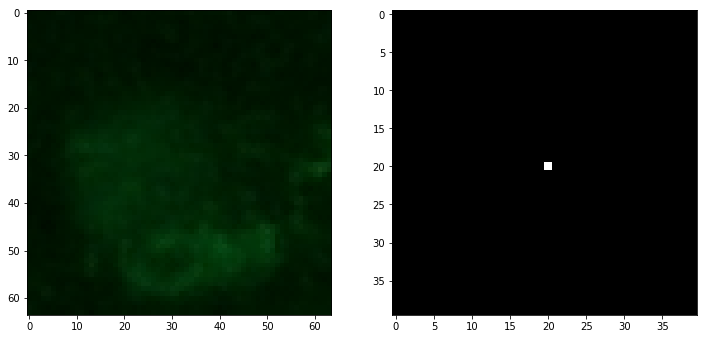

39 Mar27b 512 506


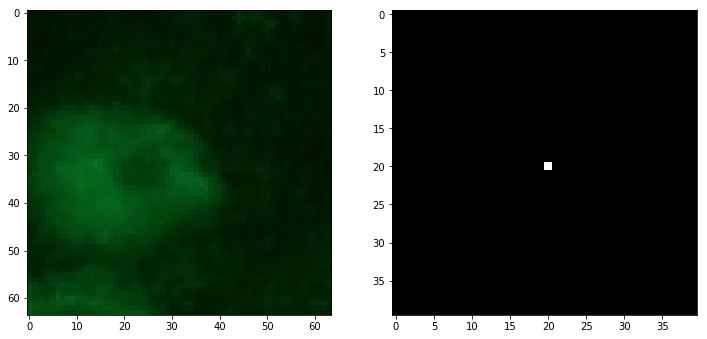

40 Mar27b 542 490


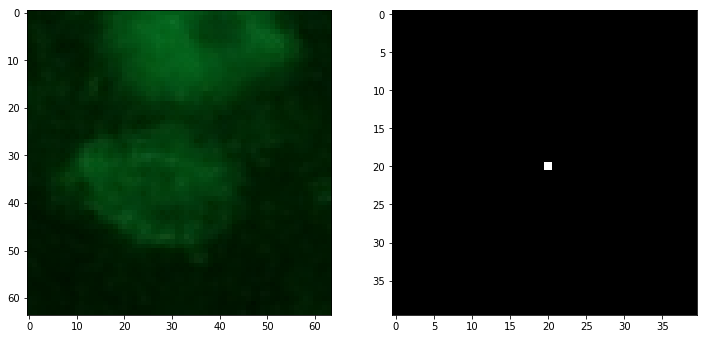

41 Mar27b 644 602


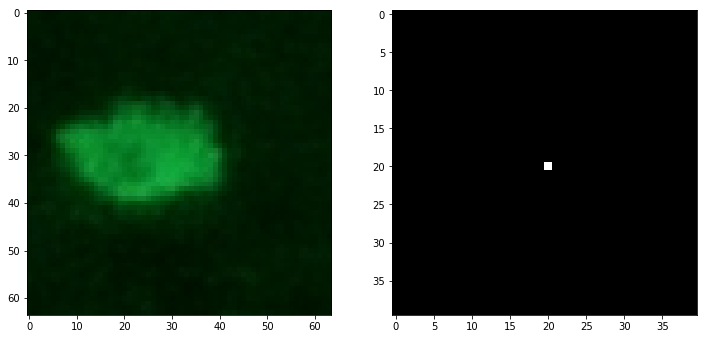

42 Mar27b 642 822


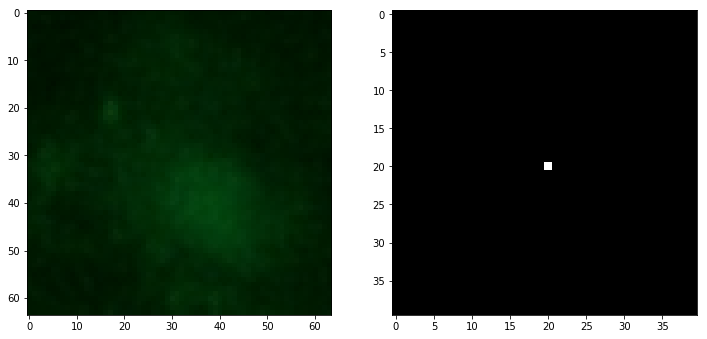

43 Mar27b 580 962


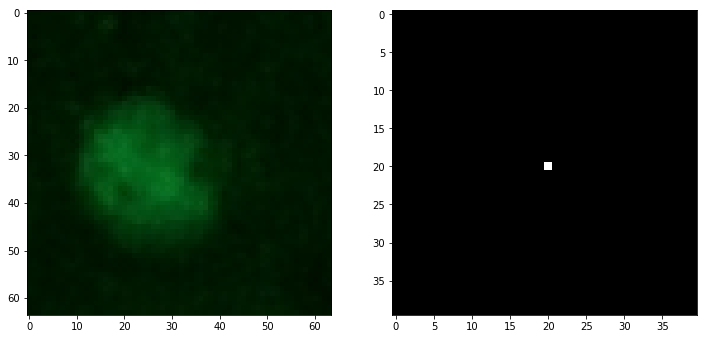

44 Mar27b 658 1016


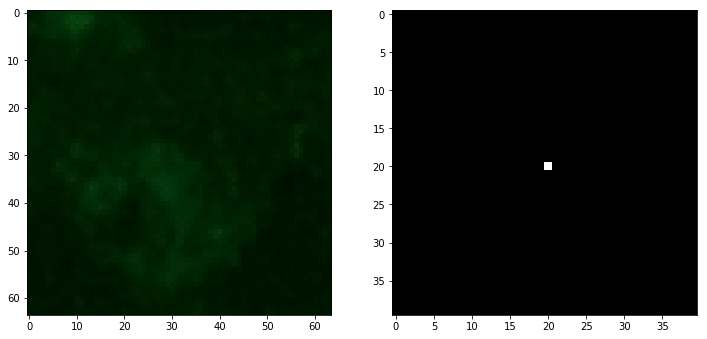

45 Mar27b 712 1002


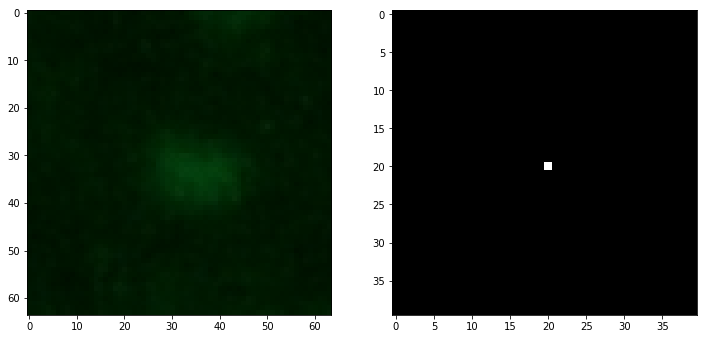

46 Mar27b 862 1146


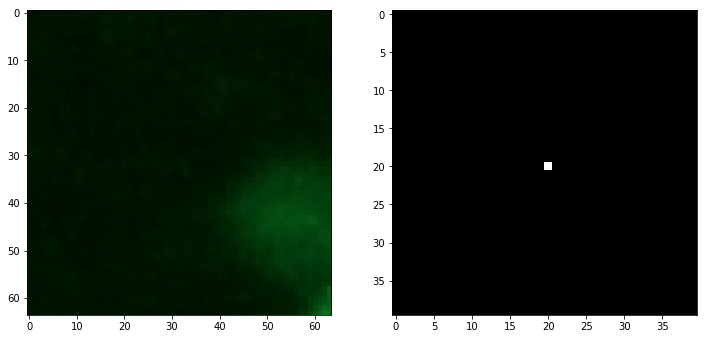

47 Mar27b 896 1178


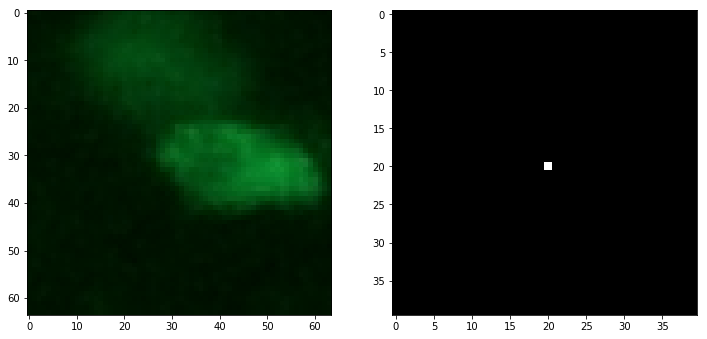

48 Mar27b 992 1272


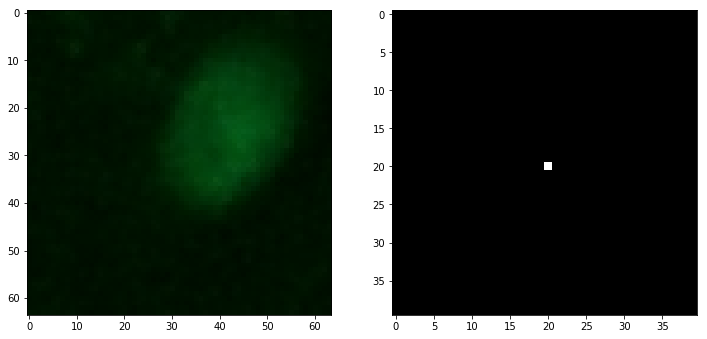

49 Mar27b 918 1348


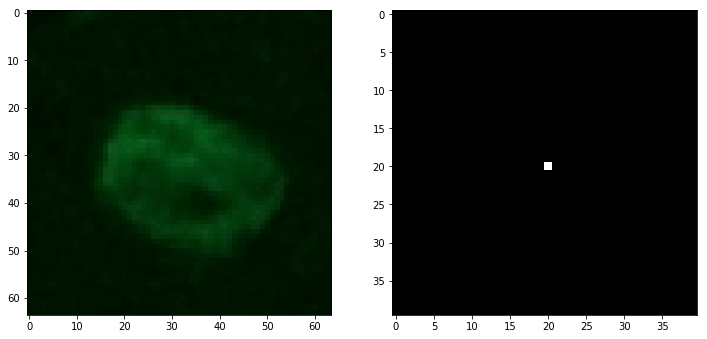

50 Mar27b 936 1574


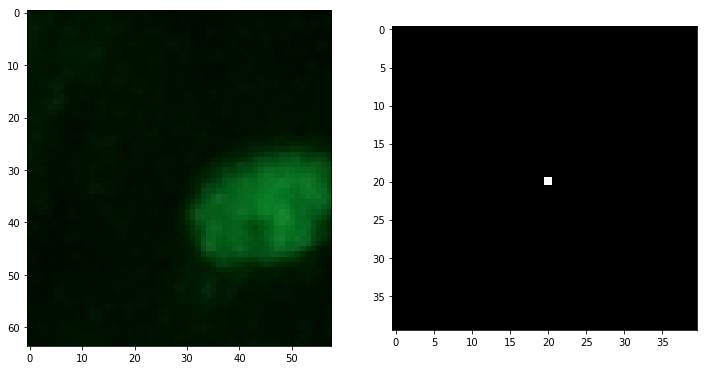

51 Mar27b 1050 1534


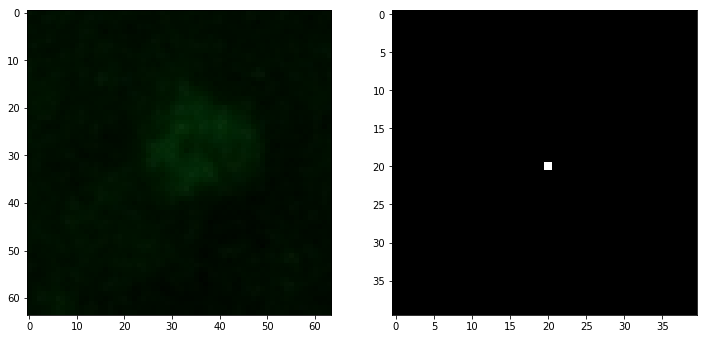

52 Mar27b 1036 1416


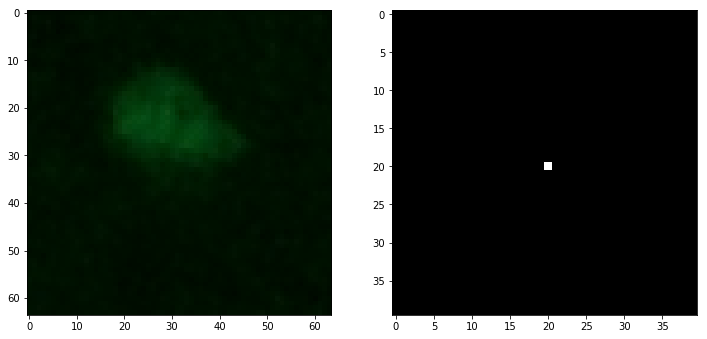

53 Mar27b 1038 1138


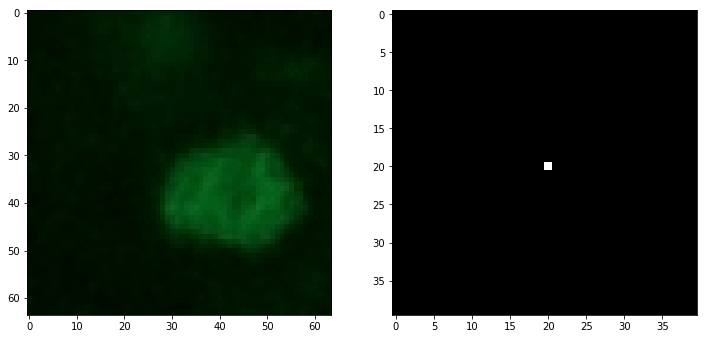

54 Mar27b 938 1058


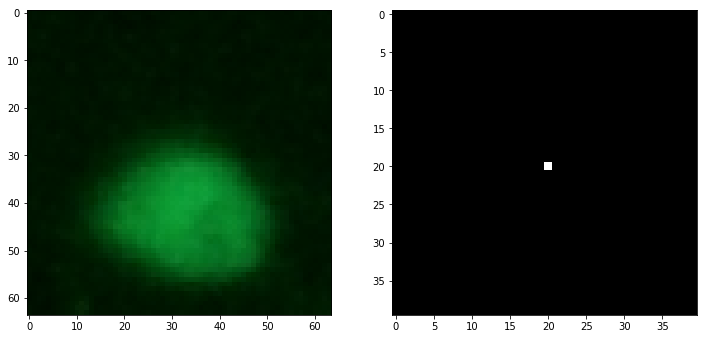

55 Mar27b 772 924


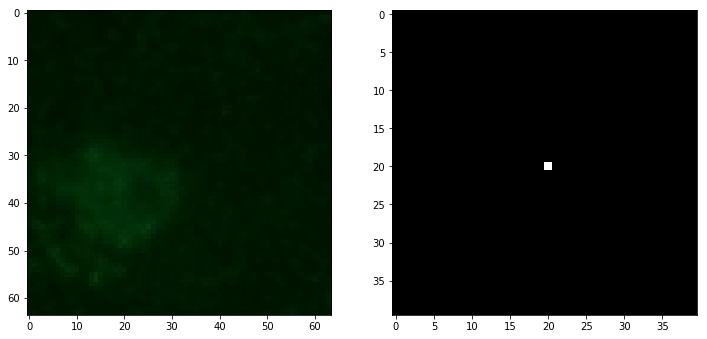

56 Mar27b 792 802


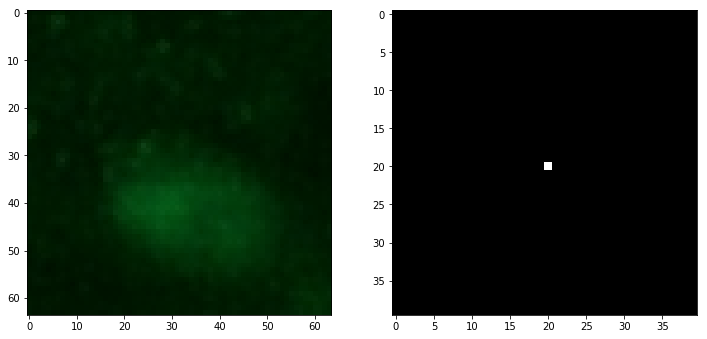

57 Mar27b 836 664


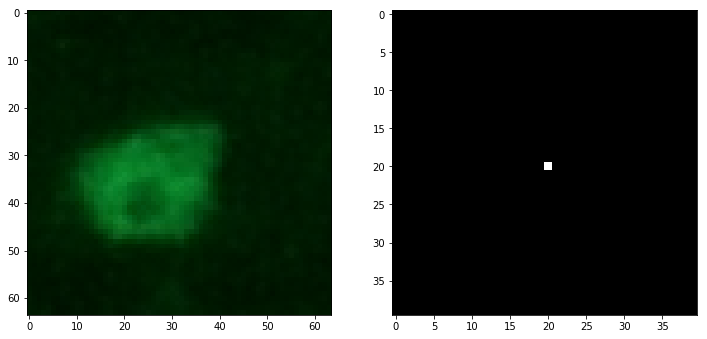

58 Mar27b 778 652


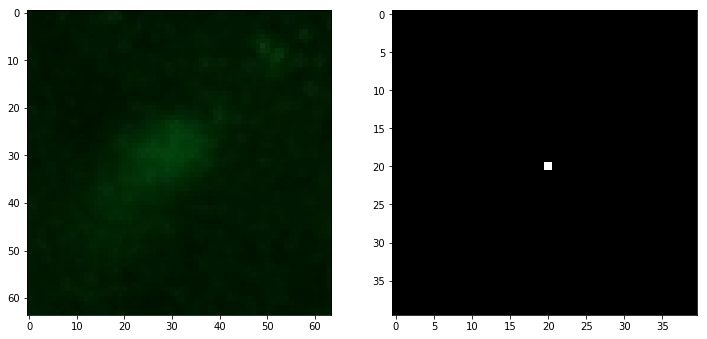

59 Mar27b 822 556


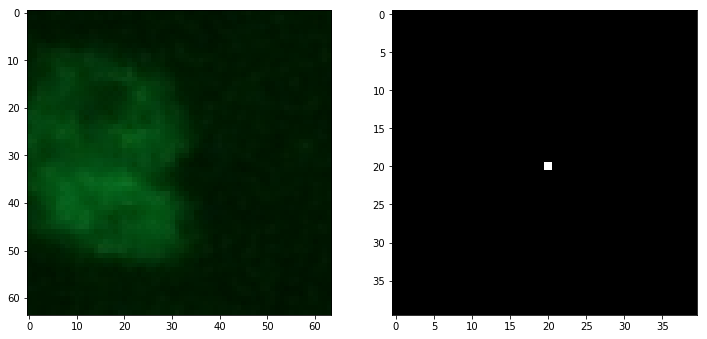

60 Mar27b 854 450


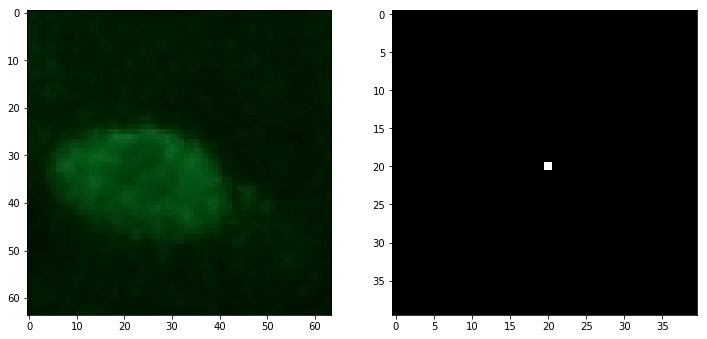

61 Mar27b 820 528


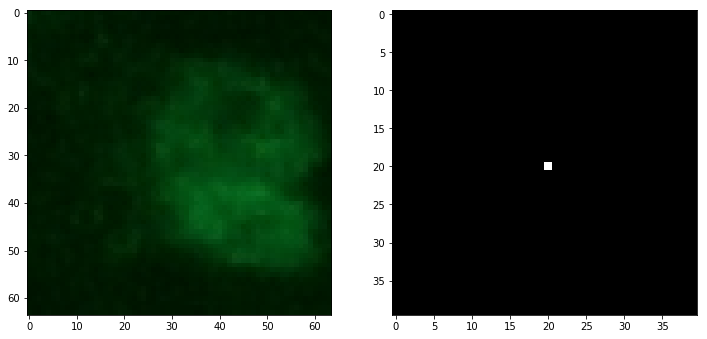

62 Mar27b 738 382


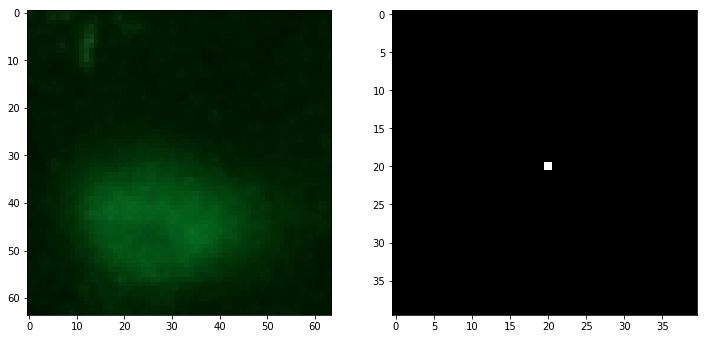

63 Mar27b 672 418


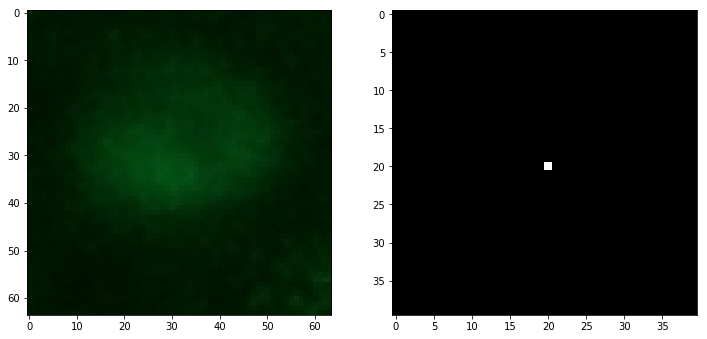

64 Mar27b 650 298


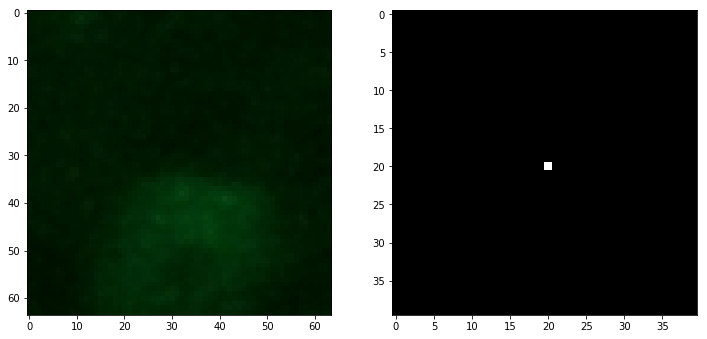

65 Mar27b 606 344


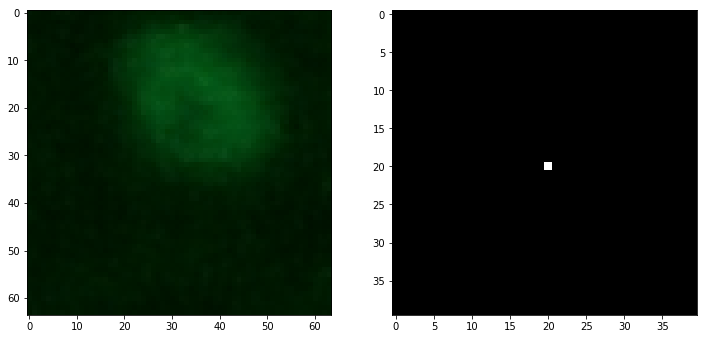

66 Mar27b 662 232


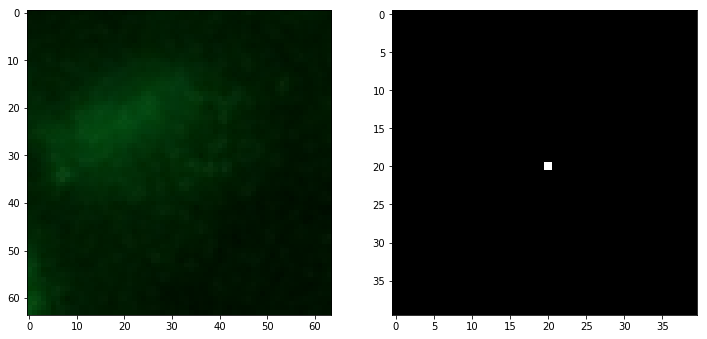

67 Mar27b 682 176


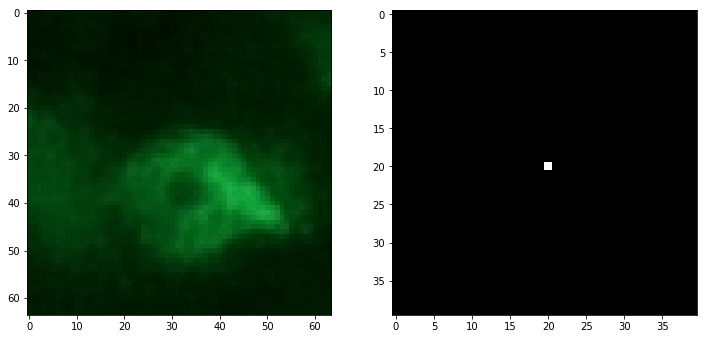

68 Mar27b 682 138


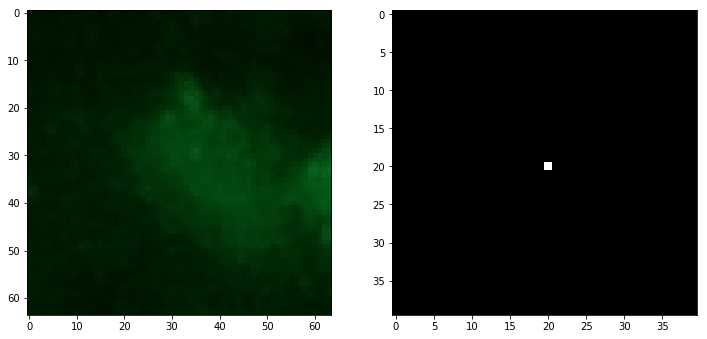

69 Mar27b 800 166


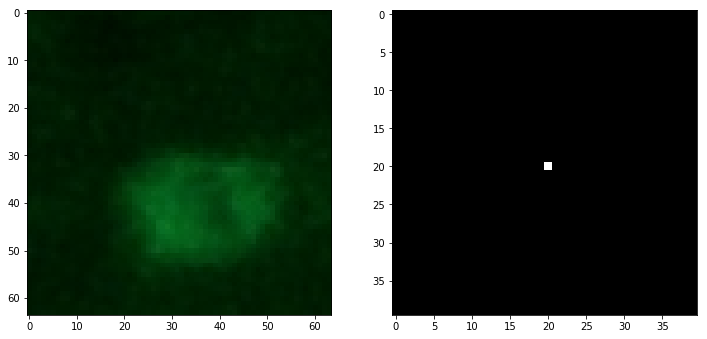

70 Mar27b 790 60


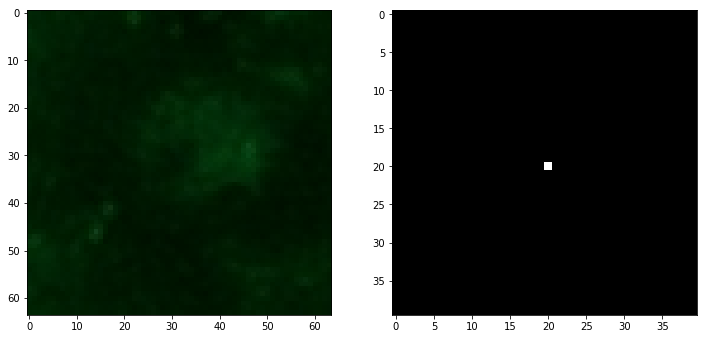

71 Mar27b 834 6
Not possible to draw 32x32 window around dot annotation.

72 Mar27b 858 60


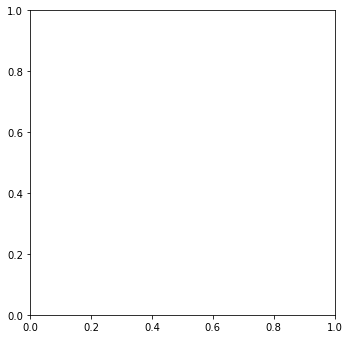

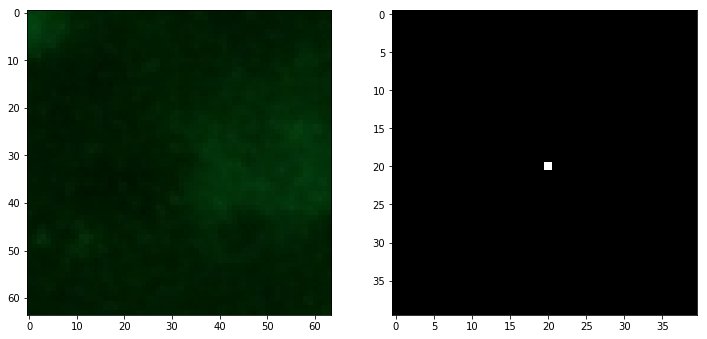

73 Mar27b 956 148


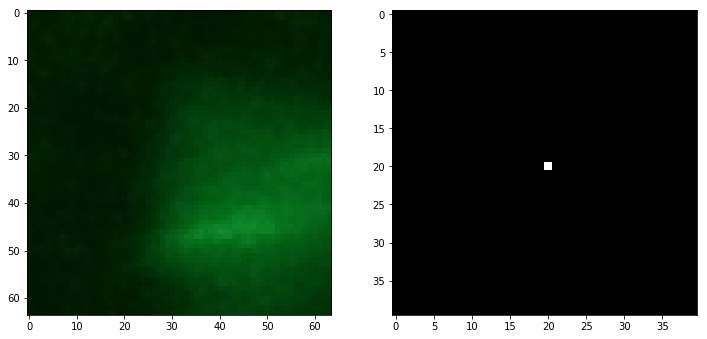

74 Mar27b 868 258


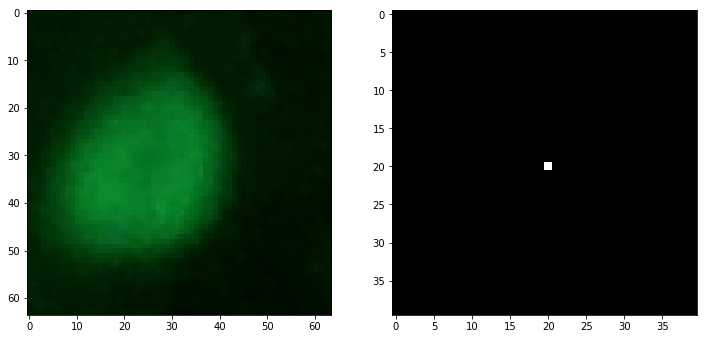

75 Mar27b 984 326


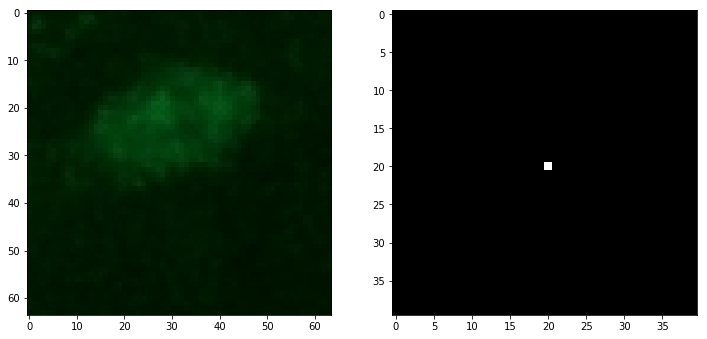

76 Mar27b 1062 260


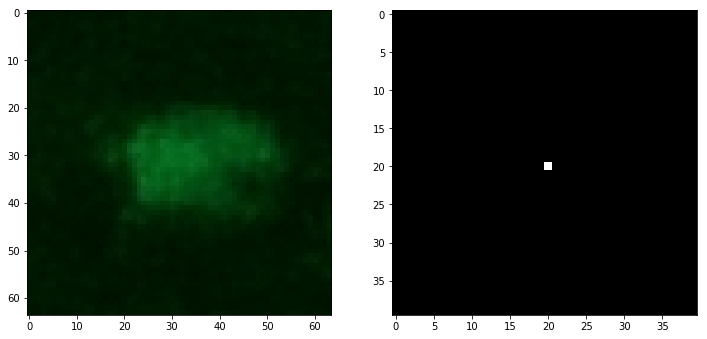

77 Mar27b 1042 108


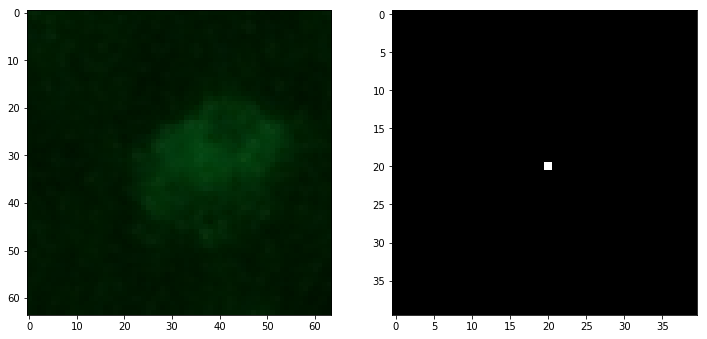

78 Mar27b 1054 36


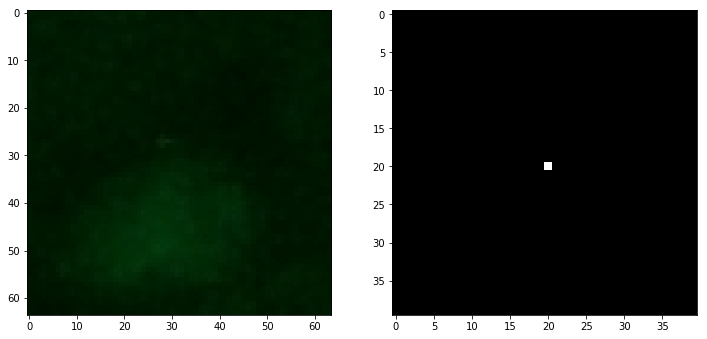

79 Mar27b 1140 266


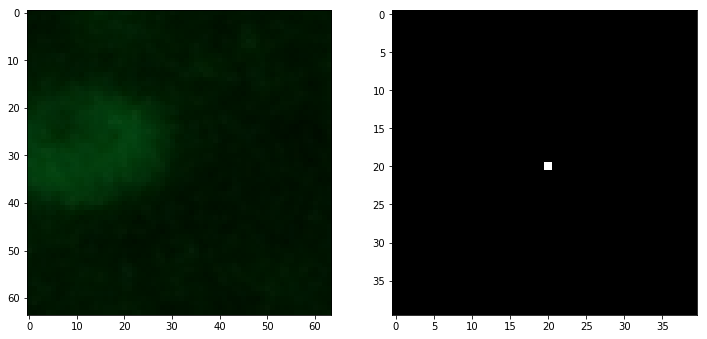

80 Mar27b 124 1092


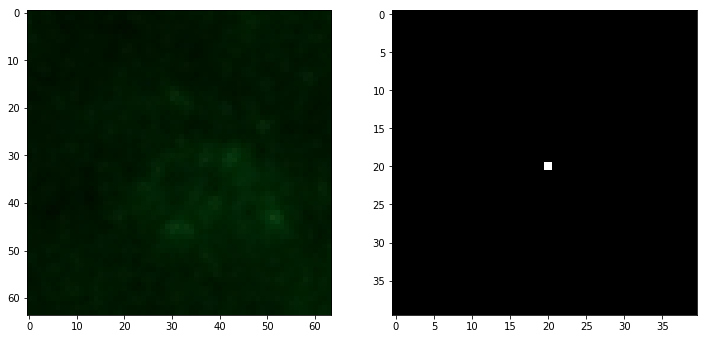

81 Mar27b 1072 414


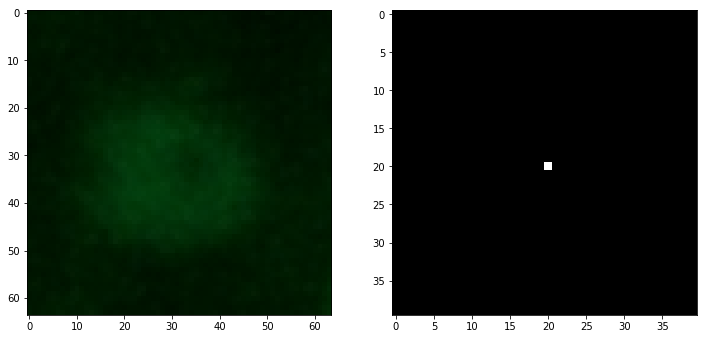

82 Mar27b 1088 450


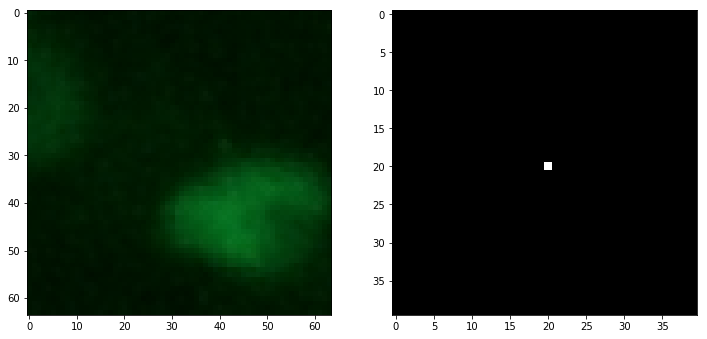

83 Mar27b 998 678


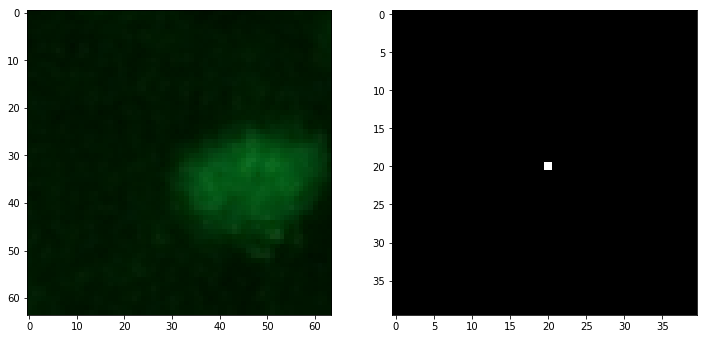

84 Mar27b 980 704


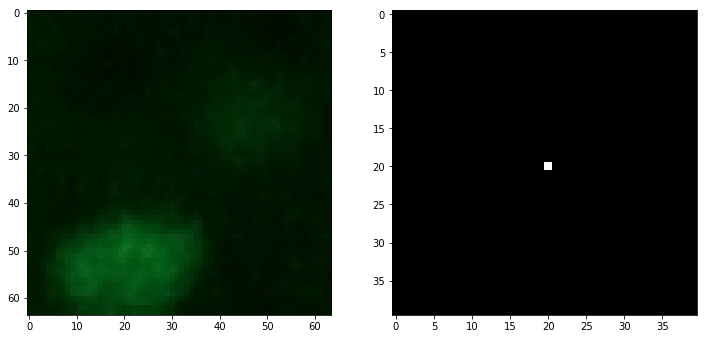

85 Mar27b 968 776


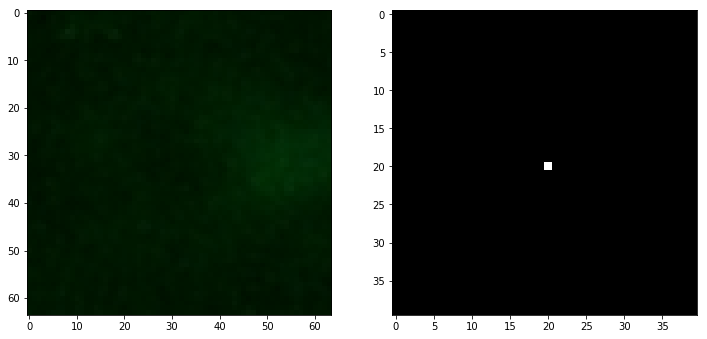

86 Mar27b 1044 880


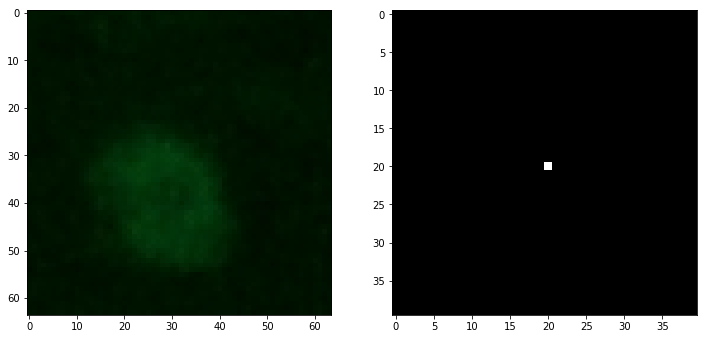

87 Mar27b 1154 1022


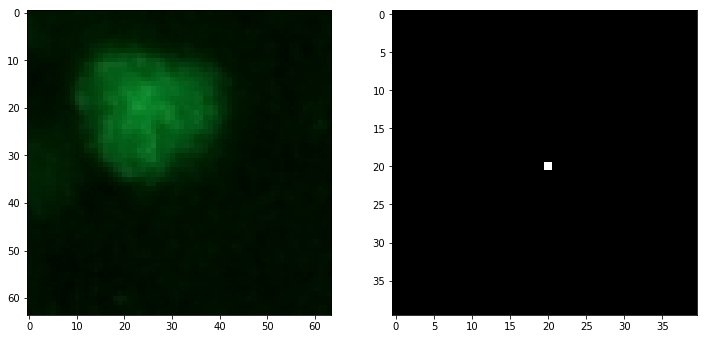

88 Mar27b 1144 852


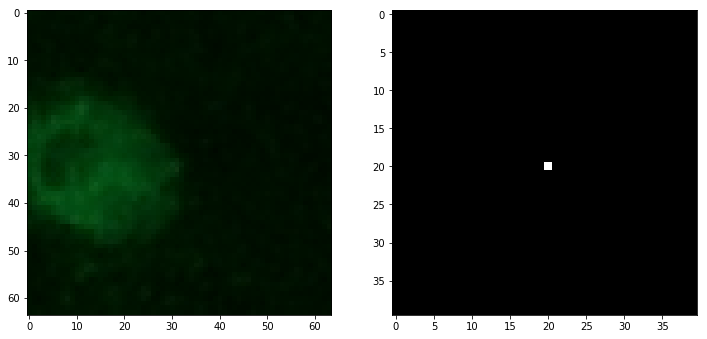

89 Mar27b 1152 692


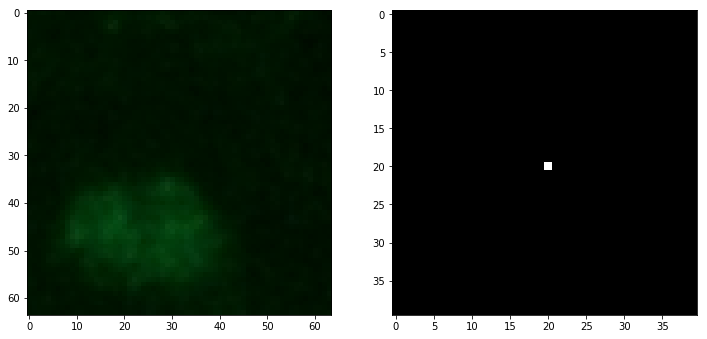

90 Mar27b 138 476


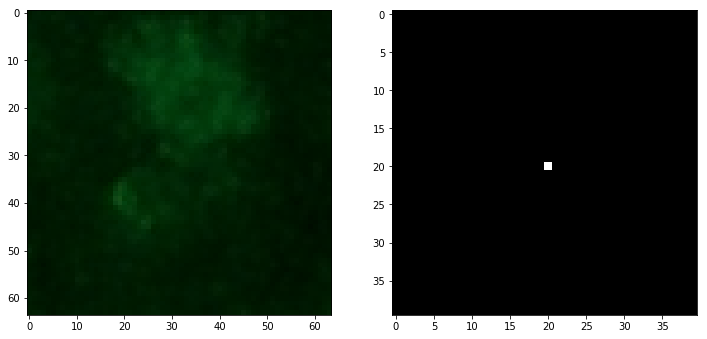

91 Mar27b 40 448


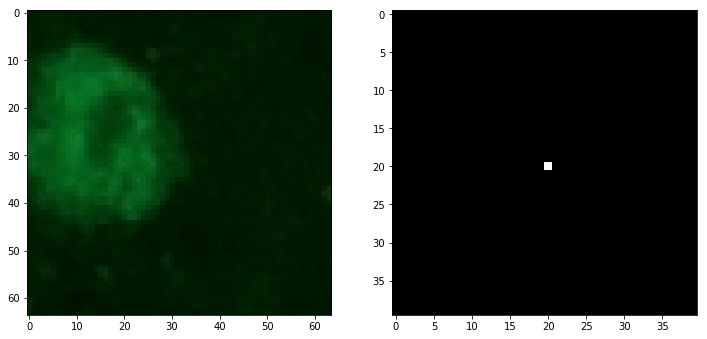

92 Mar27b 70 348


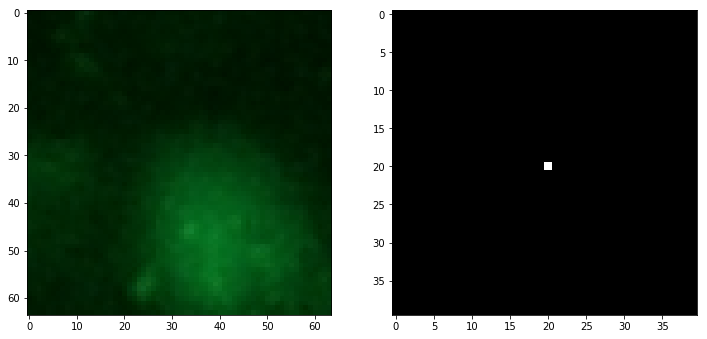

93 Mar27b 106 392


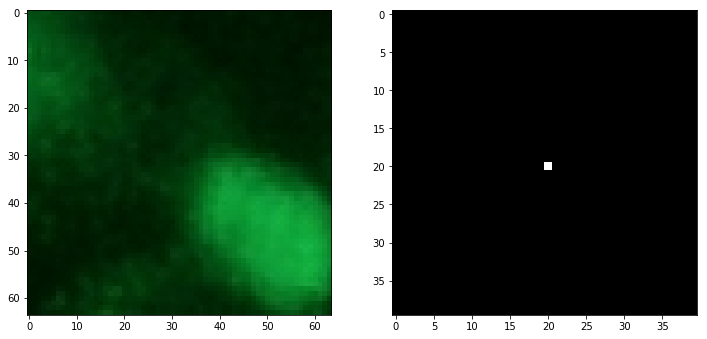

94 Mar27b 156 454


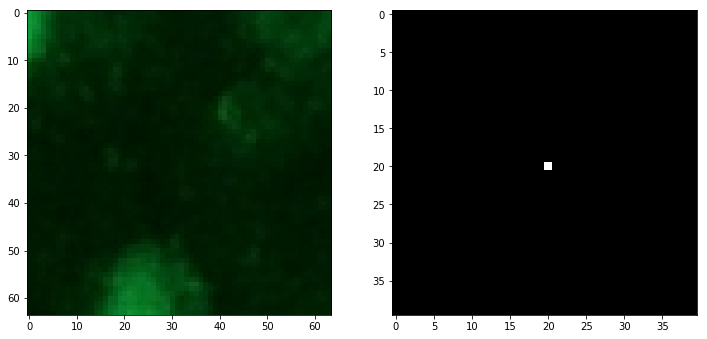

95 Mar27b 178 412


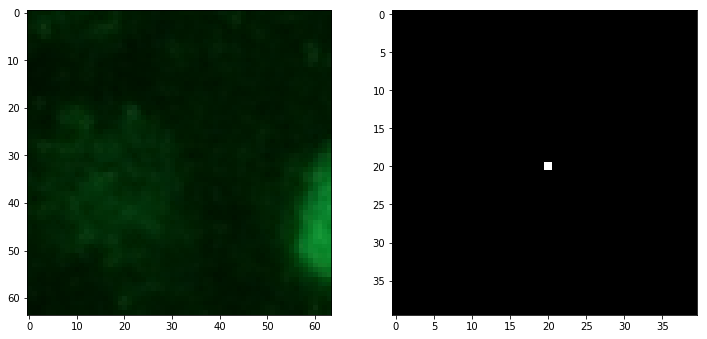

96 Mar27b 206 314


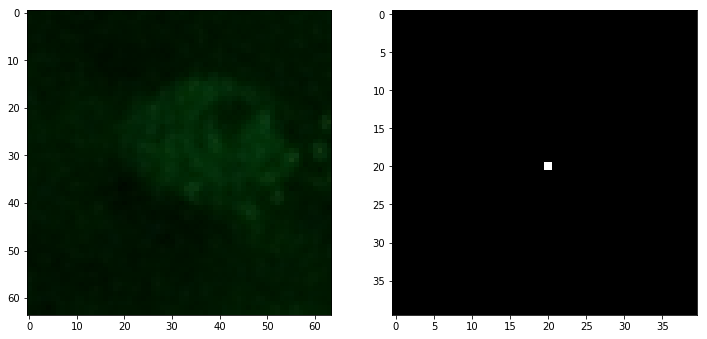

97 Mar27b 236 336


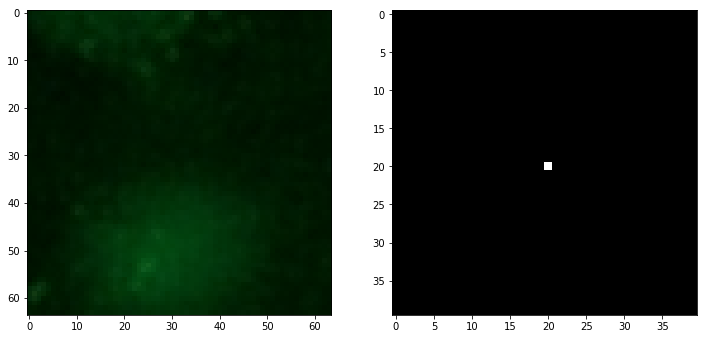

98 Mar27b 294 344


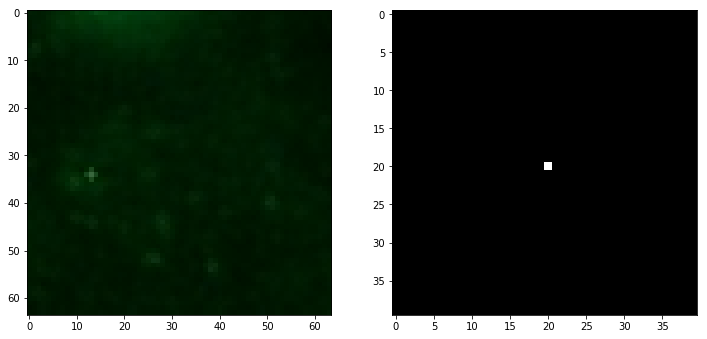

99 Mar27b 338 364


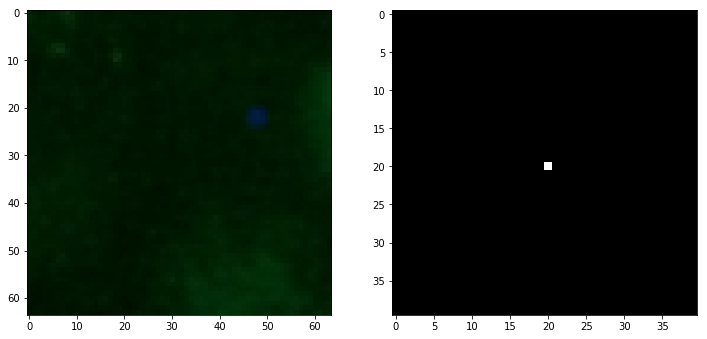

100 Mar27b 328 398


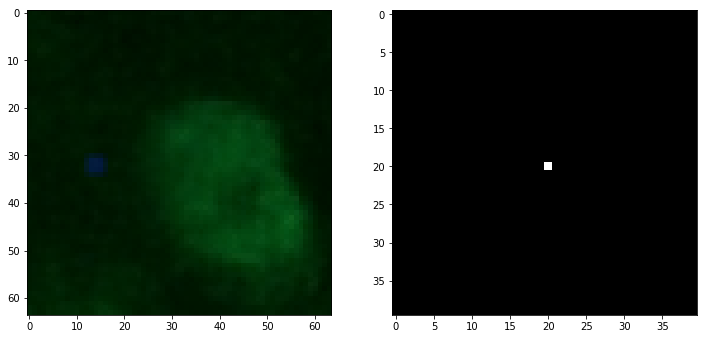

101 Mar27b 414 396


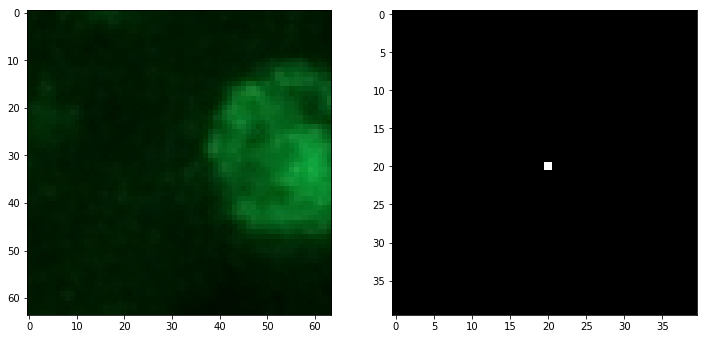

102 Mar27b 222 480


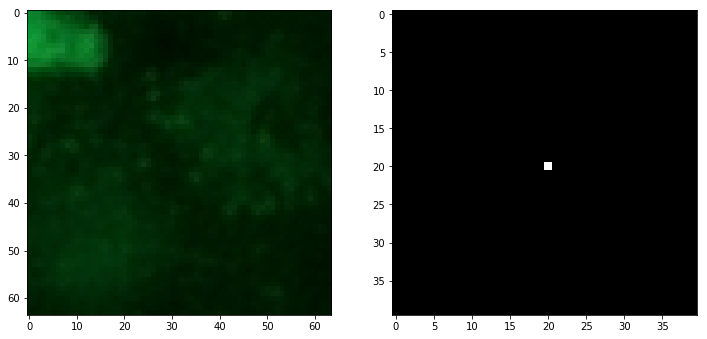

103 Mar27b 354 514


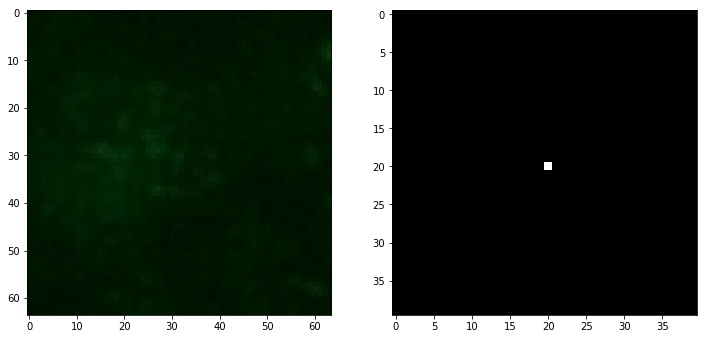

104 Mar27b 392 272


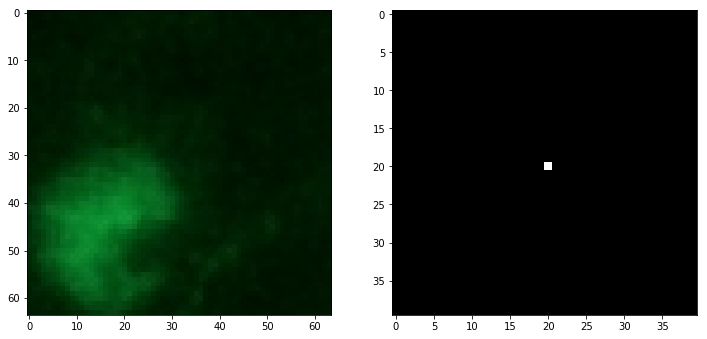

105 Mar27b 406 230


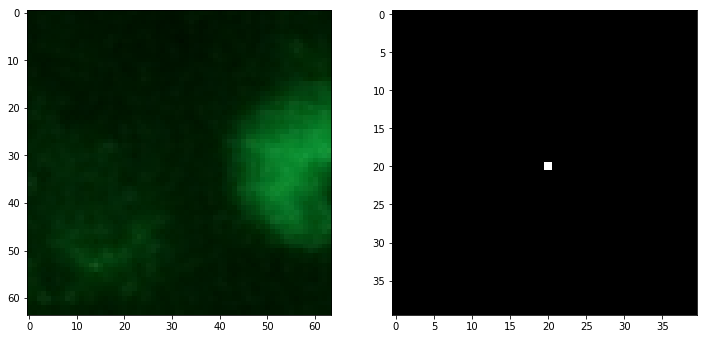

106 Mar27b 472 234


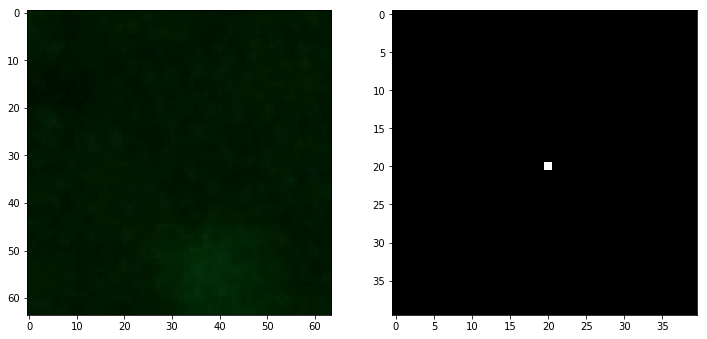

107 Mar27b 300 190


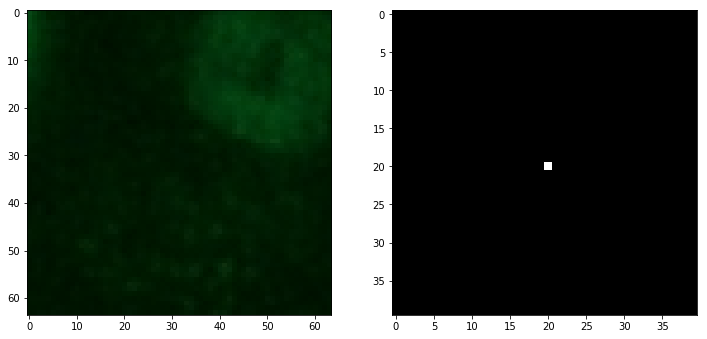

108 Mar27b 278 136


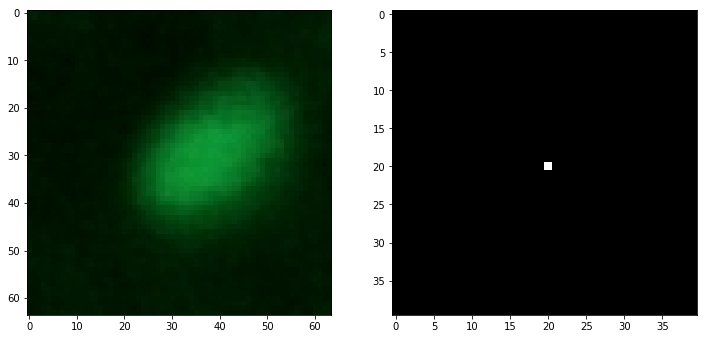

109 Mar27b 258 60


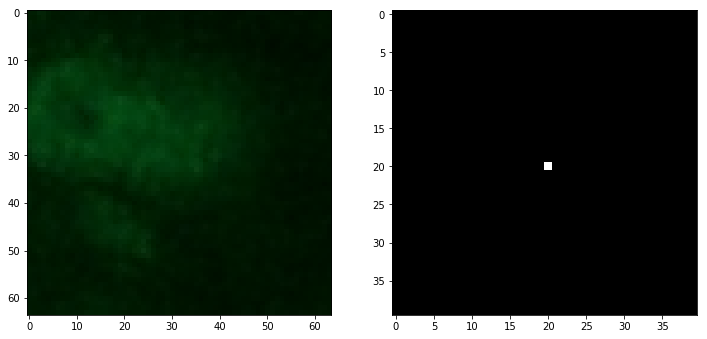

110 Mar27b 68 12
Not possible to draw 32x32 window around dot annotation.

111 Mar27b 66 152


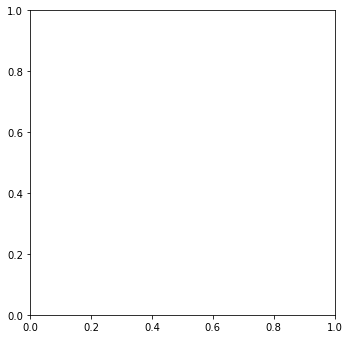

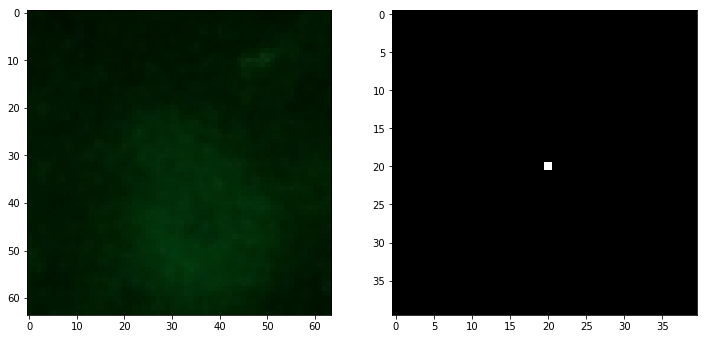

112 Mar27b 142 210


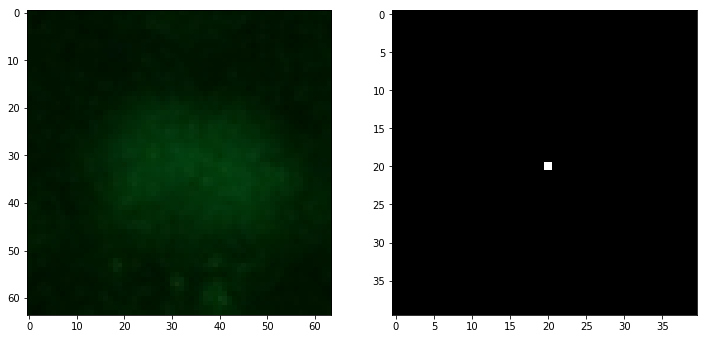

113 Mar27b 146 178


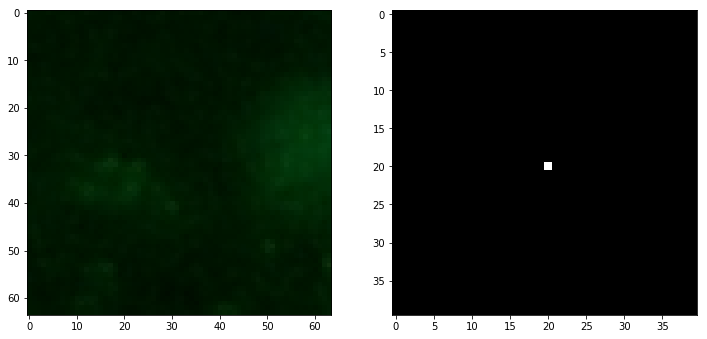

114 Mar27b 518 56


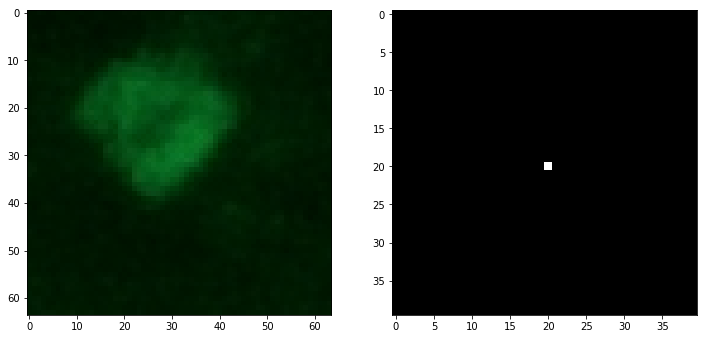

115 Mar27b 164 920


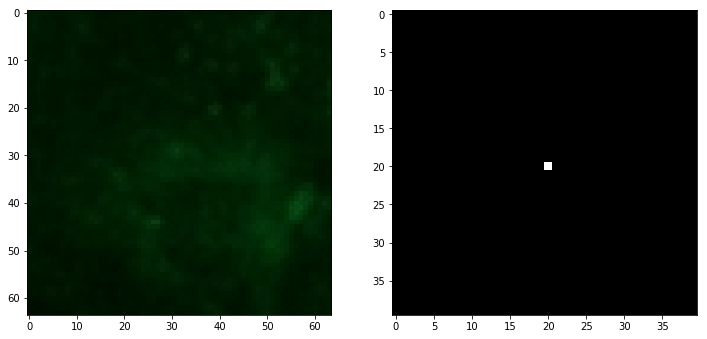

In [37]:
original_image_path = RAW_DATA_PATH / folder / full_map.loc[element_to_inspect]["original_name"]
img = cv2.imread(str(original_image_path), cv2.IMREAD_COLOR)
# backtransform to RGB
img = img[:, :, ::-1]

for i in range(len(numeric_coordinates)):
    print(i, folder, numeric_coordinates[i][1], numeric_coordinates[i][0])
    try:
        plt.figure(figsize=(12,18))
        plt.subplot(1,2,1)
        plt.imshow(img[numeric_coordinates[i][1]-32:numeric_coordinates[i][1]+32, 
                      numeric_coordinates[i][0]-32:numeric_coordinates[i][0]+32,:])
        plt.subplot(1,2,2)
        plt.imshow(img3[numeric_coordinates[i][1]-20:numeric_coordinates[i][1]+20, 
                      numeric_coordinates[i][0]-20:numeric_coordinates[i][0]+20,:])
        plt.show()
    except ValueError:
        print("Not possible to draw 32x32 window around dot annotation.\n")
#     if i == 20:
#         break

### Create dotted masks and rename relative original images 

After some trials, the dotted annotations are created as single, white points. 

The output of this process is stored in *MASKS_PATH* and the relative original images are copied into *IMG_PATH*.

Both masks and images are renamed as *XXX.TIF* and a full mapping is retrievable through  *names_map_green.txt*.

In [12]:
%%time
from scipy import ndimage
import shutil

IMG_HEIGHT = 1200
IMG_WIDTH = 1600

# initialize new column for the mask name to MISSING
full_map["mask_name"] = "MISSING"

# read coordinates files per each image
for img_idx in range(full_map.shape[0]):
    folder = full_map.loc[img_idx]["folder"]
    imagepro_name = full_map.loc[img_idx]["imagepro_name"]
    # get the path of the file containing the coordinates
    coordinates_path = (RAW_DATA_PATH / folder /
                        "coordinates" / (imagepro_name + "_points_.txt"))

    # open coordinates file
    with open(str(coordinates_path), 'r') as file:

        # initialize lists for the final
        coordinates = []

        # read coordinates record from file
        for line in file:
            if line.replace(' ', '').startswith('P'):
                continue
            # filter only columns containing x/y coordinates
            coordinates.append(line.split('\t')[2:4])
            numeric_coordinates = [[int(j) for j in i] for i in coordinates]

    # initialized 3-channels black image for the mask
    img = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3], dtype=np.uint8)
    img.fill(0)
    # add a circle for each dot
    for pt in numeric_coordinates:
        img[pt[1], pt[0], :] = [255, 255, 255]

    if not len(numeric_coordinates):  # if no cells are present print a warning message
        print("\nNo coordinates in file: ", coordinates_path)
    
    # save the mask to the appropriate folder
    output_name = '{}.TIF'.format(img_idx)
    output_path = MASKS_PATH / output_name
    _, c = ndimage.label(img)

    plt.imsave(fname=str(output_path), arr=img)

    # read original image
    original_image_path = (RAW_DATA_PATH / folder /
                           full_map.loc[img_idx]["original_name"])

    # copy image with the same name as the correspondent mask
    output_path = IMG_PATH / output_name
    shutil.copy(original_image_path, output_path)

    # overwrite mask name
    full_map.loc[img_idx]["mask_name"] = output_name

CPU times: user 55.7 s, sys: 3.4 s, total: 59.1 s
Wall time: 1min 21s


In [13]:
full_map.set_index("original_name", append=False, verify_integrity=True, inplace=True)

save_path = RAW_DATA_PATH.parent / "names_map_green.txt"
full_map.to_csv(save_path, sep='\t', index_label="original_name")

## Train/Validation/Test split

In [38]:
# Retrieve image names
names_list = []
for img_path in IMG_PATH.iterdir():
    names_list.append(img_path.name)
names_list[:6]

['272.TIF', '217.TIF', '108.TIF', '278.TIF', '242.TIF', '120.TIF']

In [39]:
names_test = random.sample(names_list, 40) # ~ 15%
names_list = set(names_list) - set(names_test)

names_validation = random.sample(names_list, 81) # ~ 25%
names_list = set(names_list) - set(names_validation)

names_train = list(names_list) # ~ 60%

In [40]:
# Read back names map
save_path = RAW_DATA_PATH.parent / "names_map_green.txt"
full_map = pd.read_csv(save_path, sep='\t', index_col="original_name")

In [41]:
# Add information about the set the image belongs to
full_map["set"] = "MISSING"

for img_path in IMG_PATH.iterdir():
    for set_idx, names_list in enumerate([names_train, names_validation, names_test]):
        if img_path.name in names_list:
            full_map.loc[full_map.mask_name==img_path.name,"set"] = ["train", "validation", "test"][set_idx]

In [42]:
print("Dimensions train:\n", full_map.loc[full_map.set=="train"].shape)
full_map.loc[full_map.set=="train"].head()

Dimensions train:
 (185, 5)


,original_tag,imagepro_name,folder,mask_name,set
original_name,,,,,
RT433S4C1R2_DM_100x_g.TIF,RT433S4C1R2_DM_cFos+.tag,campione0,RT433,0.TIF,train
RT433S6C3R2_RVLM_100x_g.TIF,RT433S6C3R2_RVLM_cFos+.tag,campione1,RT433,1.TIF,train
RT433S2C2R1_Septum_100x_g.TIF,RT433S2C2R1_Septum_cFos+.tag,campione3,RT433,3.TIF,train
RT433S5C4R2_VLPAG_100x_g.TIF,RT433S5C4R2_VLPAG_cFos+.tag,campione4,RT433,4.TIF,train
RT433S5C2R2_MM_100x_g.TIF,RT433S5C2R2_MM_cFos+.tag,campione5,RT433,5.TIF,train


In [43]:
print("Dimensions validation:\n", full_map.loc[full_map.set=="validation"].shape)
full_map.loc[full_map.set=="validation"].head()

Dimensions validation:
 (81, 5)


,original_tag,imagepro_name,folder,mask_name,set
original_name,,,,,
RT433S4C1R1_ParCortex_100x_g.TIF,RT433S4C1R1_ParCortex_cFos+.tag,campione2,RT433,2.TIF,validation
Mar26bS2C2R3_LHr_200x_g.TIF,Mar26bS2C2R3_LHr_cFos+.tag,campione1,Mar26b,8.TIF,validation
Mar26bS1C2R2_VLPAGl_200x_g.TIF,Mar26bS1C2R2_VLPAGl_cFos+.tag,campione7,Mar26b,14.TIF,validation
Mar26bS2C2R2_LHl_200x_g.TIF,Mar26bS2C2R2_LHl_cFos+.tag,campione10,Mar26b,17.TIF,validation
Mar26bS2C3R1_LHr_200x_g.TIF,Mar26bS2C3R1_LHr_cFos+.tag,campione16,Mar26b,23.TIF,validation


In [44]:
print("Dimensions test:\n", full_map.loc[full_map.set=="test"].shape)
full_map.loc[full_map.set=="test"].head()

Dimensions test:
 (40, 5)


,original_tag,imagepro_name,folder,mask_name,set
original_name,,,,,
Mar26bS2C1R1_DMr_200x_g.TIF,Mar26bS2C1R1_DMr_cFos+.tag,campione3,Mar26b,10.TIF,test
Mar26bS1C4R2_DMr_200x_g.TIF,Mar26bS1C4R2_DMr_cFos+.tag,campione5,Mar26b,12.TIF,test
Mar26bS2C3R1_LHl_200x_g.TIF,Mar26bS2C3R1_LHl_cFos+.tag,campione11,Mar26b,18.TIF,test
Mar26bS1C2R3_VLPAGl_200x_g.TIF,Mar26bS1C2R3_VLPAGl_cFos+.tag,campione13,Mar26b,20.TIF,test
Mar26bS1C4R3_DMl_200x_g.TIF,Mar26bS1C4R3_DMl_cFos+.tag,campione14,Mar26b,21.TIF,test


In [ ]:
save_path = RAW_DATA_PATH.parent / "names_map_green.txt"
full_map.to_csv(save_path, sep='\t', index_label="original_name")

## Join DataFrame with additional features and training names

In [56]:
# Read back additional features
save_path = RAW_DATA_PATH.parent / "additional_features.txt"
additional_features = pd.read_csv(save_path, sep='\t', index_col="original_name")

training_features = pd.merge(full_map, additional_features, on="original_name", how="left")

In [57]:
training_features.drop(columns=["original_tag", "imagepro_name", "folder", "color"], inplace=True)
training_features.set_index("mask_name", append=False, verify_integrity=True, inplace=True)

save_path = RAW_DATA_PATH.parent / "training_features.txt"
full_map.to_csv(save_path, sep='\t', index_label="image_name")

In [58]:
training_features.head()

,set,col,idx,row,sample,tissue,zoom
mask_name,,,,,,,
0.TIF,train,C1,RT433,R2,S4,DM,100x
1.TIF,train,C3,RT433,R2,S6,RVLM,100x
2.TIF,validation,C1,RT433,R1,S4,ParCortex,100x
3.TIF,train,C2,RT433,R1,S2,Septum,100x
4.TIF,train,C4,RT433,R2,S5,VLPAG,100x


# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here